Install Packages
###


In [262]:
# !pip3 install yfinance --upgrade --no-cache-dir --user
# !pip3 install pandas --upgrade --no-cache-dir --user
# !pip3 install pandas_ta --upgrade --no-cache-dir --user
# !pip3 install PyPortfolioOpt --upgrade --no-cache-dir --user
# !pip3 install tensorflow --upgrade --no-cache-dir --user
# !pip3 install matplotlib --upgrade --no-cache-dir --user
# !pip3 install seaborn --upgrade --no-cache-dir --user

Load Libraries
###

In [263]:
# Load Packages
import itertools
import numpy as np
import pandas as pd
#from pandas_datareader import data
import matplotlib.pyplot as plt
import yfinance as yf
%matplotlib inline
import pandas_ta
import warnings
warnings.filterwarnings('ignore')


import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, LSTM, GRU, Input, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

#https://inside-machinelearning.com/en/tensorflow-random-seed/
SEED = 0
np.random.seed(SEED)
# tf.config.experimental.enable_op_determinism()
tf.keras.utils.set_random_seed(SEED)

#from statsmodels.regression.rolling import RollingOLS
#import pandas_datareader.data as web
##import matplotlib.pyplot as plt
##import statsmodels.api as sm
##import pandas as pd
##import numpy as np
#import datetime as dt
##import yfinance as yf


In [264]:
# Import data

#Mira - não ciclicas (Escolhas)
# Energia Elétrica - Energia Eletrica 
# 'CMIG3.SA', 'ALUP11.SA','ELET3.SA','EGIE3.SA','CPLE6.SA'
# Intermediarios Finaneiros - Bancos
# 'BBAS3.SA', 'BPAC11.SA','BBDC4.SA','ITUB4.SA','SANB11.SA'
# Agua e Saneamento - Agua e Saneamento 
# 'AMBP3.SA', 'CSMG3.SA', 'SAPR4.SA', 'SBSP3.SA', 'ORVR3.SA'
# #Previdencia e Seguros - Seguradoras
# 'BBSE3.SA', 'CXSE3.SA', 'PSSA3.SA'

tickers2 = {}
tickers2['energia'] = ['CMIG3.SA', 'ALUP11.SA','ELET3.SA','EGIE3.SA','CPLE6.SA']
tickers2['banco'] = ['BBAS3.SA', 'BPAC11.SA','BBDC4.SA','ITUB4.SA','SANB11.SA']
#tickers2['banco'] = ['BBAS3.SA', 'BPAC11.SA','BBDC4.SA','SANB11.SA']
#tickers2['saneamento'] = ['AMBP3.SA', 'CSMG3.SA', 'SAPR4.SA', 'SBSP3.SA', 'ORVR3.SA']
tickers2['saneamento'] = ['CSMG3.SA', 'SAPR4.SA', 'SBSP3.SA']
#tickers2['seguradora'] = ['BBSE3.SA', 'CXSE3.SA', 'PSSA3.SA']
tickers2['seguradora'] = ['BBSE3.SA', 'PSSA3.SA']
#tickers2['indice'] = ['^BVSP']

#end_date = '2023-12-31'
end_date = '2023-10-15'
#start_date = pd.to_datetime(end_date)-pd.DateOffset(365*3-1-31-28-31-30)
start_date = pd.to_datetime(end_date)-pd.DateOffset(years=5)
print(start_date)
#start_date = '2021-05-01'

tickers = [item for sublist in tickers2.values() for item in sublist]
print(tickers)
   
df = yf.download(
  tickers
  ,start = start_date, end= end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df


[****************      33%                       ]  5 of 15 completed

2018-10-15 00:00:00
['CMIG3.SA', 'ALUP11.SA', 'ELET3.SA', 'EGIE3.SA', 'CPLE6.SA', 'BBAS3.SA', 'BPAC11.SA', 'BBDC4.SA', 'ITUB4.SA', 'SANB11.SA', 'CSMG3.SA', 'SAPR4.SA', 'SBSP3.SA', 'BBSE3.SA', 'PSSA3.SA']


[*********************100%***********************]  15 of 15 completed


Price                                adj close      close       high  \
date                      ticker                                       
2018-10-15 00:00:00+00:00 ALUP11.SA  11.595334  14.792899  15.005547   
                          BBAS3.SA   12.613392  18.860001  19.219999   
                          BBDC4.SA   14.439326  20.097670  20.323065   
                          BBSE3.SA   16.189501  27.000000  27.799999   
                          BPAC11.SA   4.445213   5.112500   5.242500   
...                                        ...        ...        ...   
2023-10-13 00:00:00+00:00 ITUB4.SA   25.830740  27.690001  28.090000   
                          PSSA3.SA   25.003139  25.830000  26.280001   
                          SANB11.SA  25.634432  27.480000  28.100000   
                          SAPR4.SA    4.493306   4.720000   4.810000   
                          SBSP3.SA   60.210995  61.279999  62.830002   

Price                                      low       open    volume  
date                      ticker                                     
2018-10-15 00:00:00+00:00 ALUP11.SA  14.654215  14.654215   1650197  
                          BBAS3.SA   18.705000  18.959999  26452200  
                          BBDC4.SA   20.047583  20.216629  23334932  
                          BBSE3.SA   26.719999  27.500000   4386000  
                          BPAC11.SA   5.072500   5.242500   1124800  
...                                        ...        ...       ...  
2023-10-13 00:00:00+00:00 ITUB4.SA   27.590000  27.940001  22275500  
                          PSSA3.SA   25.469999  26.190001   1163400  
                          SANB11.SA  27.410000  28.100000   1531400  
                          SAPR4.SA    4.600000   4.630000   3752100  
                          SBSP3.SA   61.189999  62.500000   2108300  

[18600 rows x 6 columns]

In [265]:
'''
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

#df['fin_volume'] = (df['adj close']*df['volume'])/1e6

df['sme9'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.sma(close=x, length=9))
df['sme72'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.sma(close=x, length=72))

df
'''

"\ndf['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)\n\ndf['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))\n\ndf['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])\n                                                          \ndf['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])\n                                                          \ndf['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])\n\ndef compute_atr(stock_data):\n    atr = pandas_ta.atr(high=stock_data['high'],\n                        low=stock_data['low'],\n                        close=stock_data['close'],\n                        length=14)\n    return atr.sub(atr.mean()).div

In [266]:
#df1=df['Adj Close']
df1=df.unstack('ticker')['adj close']
df1

ticker                     ALUP11.SA   BBAS3.SA   BBDC4.SA   BBSE3.SA  \
date                                                                    
2018-10-15 00:00:00+00:00  11.595334  12.613392  14.439326  16.189501   
2018-10-16 00:00:00+00:00  11.885218  13.165141  15.127561  16.309425   
2018-10-17 00:00:00+00:00  12.102629  13.278835  15.145552  16.189501   
2018-10-18 00:00:00+00:00  12.066394  13.125013  14.727212  15.829736   
2018-10-19 00:00:00+00:00  12.291053  13.235368  14.776695  15.847727   
...                              ...        ...        ...        ...   
2023-10-06 00:00:00+00:00  26.225849  22.981741  13.447276  29.745079   
2023-10-09 00:00:00+00:00  26.308638  22.859425  13.326465  29.568851   
2023-10-10 00:00:00+00:00  26.547808  22.821785  13.475156  29.336977   
2023-10-11 00:00:00+00:00  26.575403  23.038195  13.670314  29.448277   
2023-10-13 00:00:00+00:00  26.014277  22.967627  13.465862  29.030899   

ticker                     BPAC11.SA   CMIG3.SA  CPLE6.SA   CSMG3.SA  \
date                                                                   
2018-10-15 00:00:00+00:00   4.445213   3.156588  1.569702   9.914710   
2018-10-16 00:00:00+00:00   4.343049   3.221008  1.572767   9.962375   
2018-10-17 00:00:00+00:00   4.447385   3.159656  1.534751   9.962375   
2018-10-18 00:00:00+00:00   4.340875   3.153520  1.520035   9.800310   
2018-10-19 00:00:00+00:00   4.330006   3.153520  1.535978   9.724044   
...                              ...        ...       ...        ...   
2023-10-06 00:00:00+00:00  30.215763  12.673260  8.169181  14.636235   
2023-10-09 00:00:00+00:00  29.981304  12.733930  8.247542  14.886060   
2023-10-10 00:00:00+00:00  30.372066  12.558660  8.365084  14.946362   
2023-10-11 00:00:00+00:00  31.153591  12.545179  8.374880  14.937747   
2023-10-13 00:00:00+00:00  30.245070  12.120489  8.198566  14.782682   

ticker                      EGIE3.SA   ELET3.SA   ITUB4.SA   PSSA3.SA  \
date                                                                    
2018-10-15 00:00:00+00:00  19.673845  17.525513  24.963717  19.388435   
2018-10-16 00:00:00+00:00  20.133791  18.420612  25.961235  19.430988   
2018-10-17 00:00:00+00:00  20.402098  17.734652  25.691072  19.026697   
2018-10-18 00:00:00+00:00  20.615646  17.274551  24.927355  18.512461   
2018-10-19 00:00:00+00:00  20.807293  18.219843  24.901381  18.923851   
...                              ...        ...        ...        ...   
2023-10-06 00:00:00+00:00  38.401863  34.427258  26.026636  25.661371   
2023-10-09 00:00:00+00:00  38.798538  35.070297  25.802748  25.574253   
2023-10-10 00:00:00+00:00  39.270763  35.881516  25.774767  25.429054   
2023-10-11 00:00:00+00:00  39.223541  36.138729  26.101265  25.361298   
2023-10-13 00:00:00+00:00  38.562420  34.991154  25.830740  25.003139   

ticker                     SANB11.SA  SAPR4.SA   SBSP3.SA  
date                                                       
2018-10-15 00:00:00+00:00  26.144833  2.196721  24.028698  
2018-10-16 00:00:00+00:00  27.000315  2.178025  24.133703  
2018-10-17 00:00:00+00:00  27.085865  2.201395  24.571224  
2018-10-18 00:00:00+00:00  26.421219  2.189710  23.836187  
2018-10-19 00:00:00+00:00  26.368582  2.208406  24.422468  
...                              ...       ...        ...  
2023-10-06 00:00:00+00:00  25.363911  4.236273  59.140007  
2023-10-09 00:00:00+00:00  25.587791  4.398108  60.181519  
2023-10-10 00:00:00+00:00  25.895628  4.398108  61.390060  
2023-10-11 00:00:00+00:00  26.100853  4.417148  61.085468  
2023-10-13 00:00:00+00:00  25.634432  4.493306  60.210995  

[1240 rows x 15 columns]

In [267]:
len(df1.columns)

15

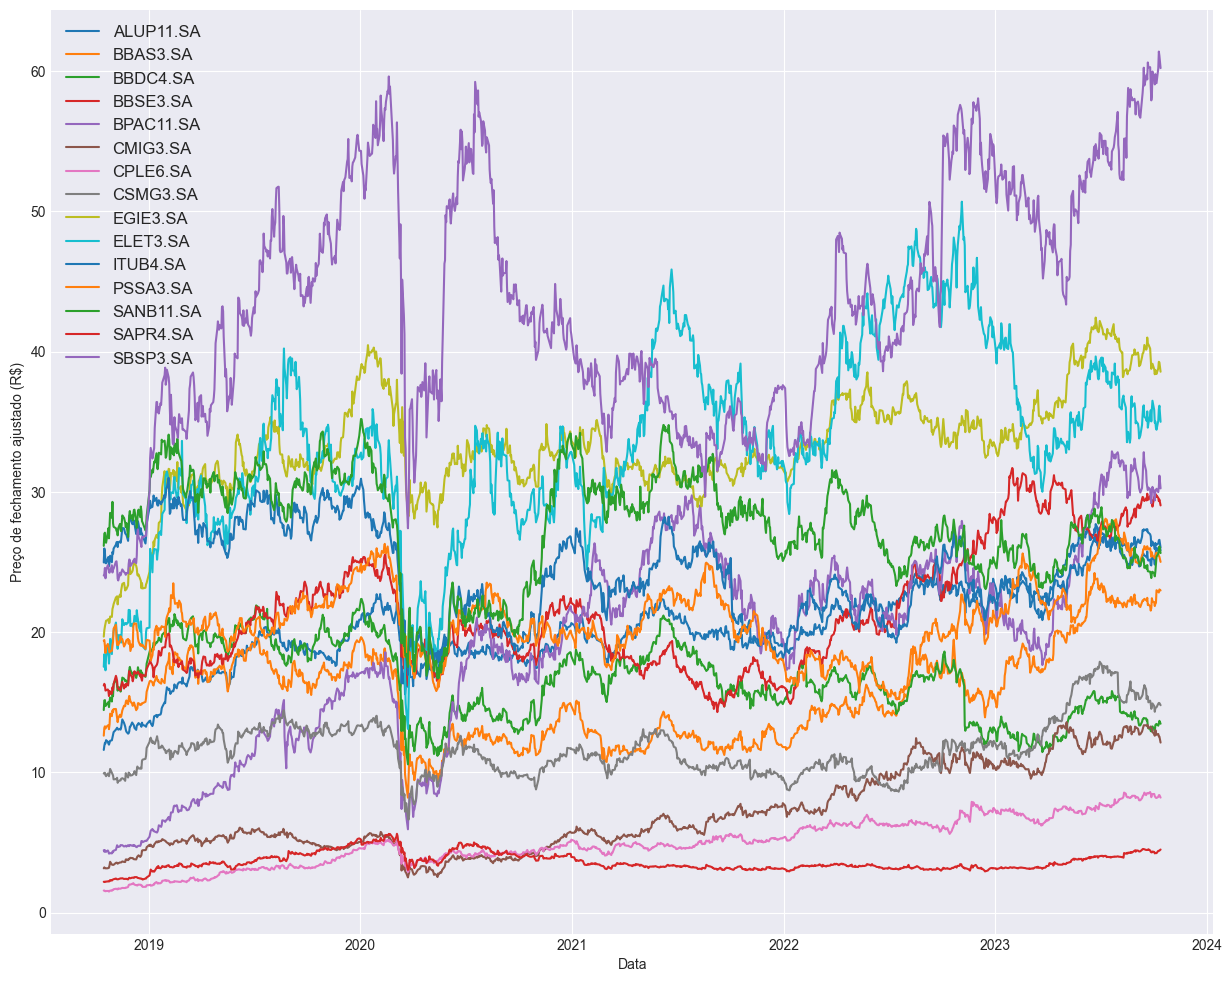

In [268]:
plt.figure(figsize=(15, 12))
for i in range(df1.shape[1]):
    plt.plot(df1.iloc[:,i], label=df1.columns.values[i])
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Preço de fechamento ajustado (R$)')
plt.xlabel('Data')
plt.show()

Codigos EGF 13
###

In [269]:
# Log of percentage change
cov_matrix = df1.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

ticker     ALUP11.SA  BBAS3.SA  BBDC4.SA  BBSE3.SA  BPAC11.SA  CMIG3.SA  \
ticker                                                                    
ALUP11.SA   0.000240  0.000179  0.000159  0.000101   0.000235  0.000194   
BBAS3.SA    0.000179  0.000603  0.000450  0.000232   0.000441  0.000362   
BBDC4.SA    0.000159  0.000450  0.000563  0.000202   0.000423  0.000304   
BBSE3.SA    0.000101  0.000232  0.000202  0.000312   0.000256  0.000193   
BPAC11.SA   0.000235  0.000441  0.000423  0.000256   0.001044  0.000427   
CMIG3.SA    0.000194  0.000362  0.000304  0.000193   0.000427  0.000651   
CPLE6.SA    0.000188  0.000308  0.000268  0.000163   0.000356  0.000356   
CSMG3.SA    0.000187  0.000281  0.000239  0.000147   0.000362  0.000360   
EGIE3.SA    0.000124  0.000197  0.000175  0.000134   0.000223  0.000213   
ELET3.SA    0.000230  0.000460  0.000391  0.000258   0.000496  0.000449   
ITUB4.SA    0.000131  0.000384  0.000420  0.000191   0.000358  0.000252   
PSSA3.SA    0.000093  0.000193  0.000171  0.000147   0.000246  0.000161   
SANB11.SA   0.000148  0.000407  0.000432  0.000209   0.000394  0.000277   
SAPR4.SA    0.000143  0.000257  0.000216  0.000135   0.000312  0.000295   
SBSP3.SA    0.000192  0.000341  0.000291  0.000172   0.000417  0.000375   

ticker     CPLE6.SA  CSMG3.SA  EGIE3.SA  ELET3.SA  ITUB4.SA  PSSA3.SA  \
ticker                                                                  
ALUP11.SA  0.000188  0.000187  0.000124  0.000230  0.000131  0.000093   
BBAS3.SA   0.000308  0.000281  0.000197  0.000460  0.000384  0.000193   
BBDC4.SA   0.000268  0.000239  0.000175  0.000391  0.000420  0.000171   
BBSE3.SA   0.000163  0.000147  0.000134  0.000258  0.000191  0.000147   
BPAC11.SA  0.000356  0.000362  0.000223  0.000496  0.000358  0.000246   
CMIG3.SA   0.000356  0.000360  0.000213  0.000449  0.000252  0.000161   
CPLE6.SA   0.000517  0.000290  0.000195  0.000396  0.000228  0.000158   
CSMG3.SA   0.000290  0.000562  0.000182  0.000385  0.000200  0.000138   
EGIE3.SA   0.000195  0.000182  0.000240  0.000263  0.000152  0.000108   
ELET3.SA   0.000396  0.000385  0.000263  0.000980  0.000337  0.000191   
ITUB4.SA   0.000228  0.000200  0.000152  0.000337  0.000442  0.000156   
PSSA3.SA   0.000158  0.000138  0.000108  0.000191  0.000156  0.000354   
SANB11.SA  0.000241  0.000214  0.000166  0.000363  0.000381  0.000171   
SAPR4.SA   0.000282  0.000311  0.000175  0.000348  0.000173  0.000124   
SBSP3.SA   0.000347  0.000411  0.000210  0.000466  0.000245  0.000157   

ticker     SANB11.SA  SAPR4.SA  SBSP3.SA  
ticker                                    
ALUP11.SA   0.000148  0.000143  0.000192  
BBAS3.SA    0.000407  0.000257  0.000341  
BBDC4.SA    0.000432  0.000216  0.000291  
BBSE3.SA    0.000209  0.000135  0.000172  
BPAC11.SA   0.000394  0.000312  0.000417  
CMIG3.SA    0.000277  0.000295  0.000375  
CPLE6.SA    0.000241  0.000282  0.000347  
CSMG3.SA    0.000214  0.000311  0.000411  
EGIE3.SA    0.000166  0.000175  0.000210  
ELET3.SA    0.000363  0.000348  0.000466  
ITUB4.SA    0.000381  0.000173  0.000245  
PSSA3.SA    0.000171  0.000124  0.000157  
SANB11.SA   0.000504  0.000190  0.000265  
SAPR4.SA    0.000190  0.000441  0.000335  
SBSP3.SA    0.000265  0.000335  0.000651

In [270]:


corr_matrix = df1.pct_change().apply(lambda x: np.log(1+x)).corr()
corr_matrix

ticker     ALUP11.SA  BBAS3.SA  BBDC4.SA  BBSE3.SA  BPAC11.SA  CMIG3.SA  \
ticker                                                                    
ALUP11.SA   1.000000  0.471073  0.433165  0.368273   0.469924  0.489452   
BBAS3.SA    0.471073  1.000000  0.772321  0.535654   0.555811  0.577521   
BBDC4.SA    0.433165  0.772321  1.000000  0.481490   0.551404  0.501903   
BBSE3.SA    0.368273  0.535654  0.481490  1.000000   0.448802  0.428017   
BPAC11.SA   0.469924  0.555811  0.551404  0.448802   1.000000  0.517636   
CMIG3.SA    0.489452  0.577521  0.501903  0.428017   0.517636  1.000000   
CPLE6.SA    0.533080  0.551620  0.496264  0.405107   0.484709  0.613834   
CSMG3.SA    0.508523  0.482588  0.425120  0.350908   0.472142  0.594732   
EGIE3.SA    0.516680  0.517080  0.475901  0.489120   0.444757  0.540405   
ELET3.SA    0.474500  0.598037  0.525932  0.467325   0.490118  0.562689   
ITUB4.SA    0.403229  0.745060  0.843003  0.515275   0.527245  0.469716   
PSSA3.SA    0.318527  0.419050  0.383893  0.441759   0.404256  0.334740   
SANB11.SA   0.425877  0.738689  0.810832  0.526934   0.543185  0.483072   
SAPR4.SA    0.438304  0.498513  0.434039  0.364982   0.459797  0.550123   
SBSP3.SA    0.484822  0.544336  0.481405  0.381619   0.506275  0.575512   

ticker     CPLE6.SA  CSMG3.SA  EGIE3.SA  ELET3.SA  ITUB4.SA  PSSA3.SA  \
ticker                                                                  
ALUP11.SA  0.533080  0.508523  0.516680  0.474500  0.403229  0.318527   
BBAS3.SA   0.551620  0.482588  0.517080  0.598037  0.745060  0.419050   
BBDC4.SA   0.496264  0.425120  0.475901  0.525932  0.843003  0.383893   
BBSE3.SA   0.405107  0.350908  0.489120  0.467325  0.515275  0.441759   
BPAC11.SA  0.484709  0.472142  0.444757  0.490118  0.527245  0.404256   
CMIG3.SA   0.613834  0.594732  0.540405  0.562689  0.469716  0.334740   
CPLE6.SA   1.000000  0.537408  0.554755  0.556443  0.477129  0.369678   
CSMG3.SA   0.537408  1.000000  0.496853  0.519444  0.401305  0.308868   
EGIE3.SA   0.554755  0.496853  1.000000  0.542093  0.467770  0.370171   
ELET3.SA   0.556443  0.519444  0.542093  1.000000  0.512330  0.324148   
ITUB4.SA   0.477129  0.401305  0.467770  0.512330  1.000000  0.394495   
PSSA3.SA   0.369678  0.308868  0.370171  0.324148  0.394495  1.000000   
SANB11.SA  0.471430  0.403156  0.478139  0.516297  0.807088  0.404055   
SAPR4.SA   0.591791  0.624615  0.537448  0.528963  0.391345  0.315289   
SBSP3.SA   0.599032  0.680007  0.530930  0.583721  0.457757  0.328250   

ticker     SANB11.SA  SAPR4.SA  SBSP3.SA  
ticker                                    
ALUP11.SA   0.425877  0.438304  0.484822  
BBAS3.SA    0.738689  0.498513  0.544336  
BBDC4.SA    0.810832  0.434039  0.481405  
BBSE3.SA    0.526934  0.364982  0.381619  
BPAC11.SA   0.543185  0.459797  0.506275  
CMIG3.SA    0.483072  0.550123  0.575512  
CPLE6.SA    0.471430  0.591791  0.599032  
CSMG3.SA    0.403156  0.624615  0.680007  
EGIE3.SA    0.478139  0.537448  0.530930  
ELET3.SA    0.516297  0.528963  0.583721  
ITUB4.SA    0.807088  0.391345  0.457757  
PSSA3.SA    0.404055  0.315289  0.328250  
SANB11.SA   1.000000  0.402655  0.463077  
SAPR4.SA    0.402655  1.000000  0.625763  
SBSP3.SA    0.463077  0.625763  1.000000

In [271]:
df1.columns
w = dict()
df1.columns.size
for i in df1.columns:
  w.setdefault(i, 1/df1.columns.size)

# w = {'CMIG3.SA': 0.05, 'ALUP11.SA': 0.05,'ELET3.SA': 0.05,'EGIE3.SA': 0.05,'CPLE6.SA': 0.05,
#     'BBAS3.SA': 0.05, 'BPAC11.SA': 0.05,'BBDC4.SA': 0.05,'ITUB4.SA': 0.05,'SANB11.SA': 0.05,
#     'AMBP3.SA': 0.05, 'CSMG3.SA': 0.05, 'SAPR4.SA': 0.05, 'SBSP3.SA': 0.05, 'ORVR3.SA': 0.05,
#     'BBSE3.SA': 0.05, 'CXSE3.SA': 0.1, 'PSSA3.SA': 0.1
#      }

port_var = cov_matrix.mul(w, axis=0).mul(w, axis=1).sum().sum()
port_var

0.00027983435297952453

In [272]:
# Yearly returns for individual companies
ind_er = df1.resample('Y').last().pct_change().mean()
ind_er

ticker
ALUP11.SA    0.161536
BBAS3.SA     0.116912
BBDC4.SA    -0.043217
BBSE3.SA     0.166048
BPAC11.SA    0.598614
CMIG3.SA     0.216464
CPLE6.SA     0.404361
CSMG3.SA     0.063113
EGIE3.SA     0.130430
ELET3.SA     0.144965
ITUB4.SA     0.008138
PSSA3.SA     0.066075
SANB11.SA   -0.008134
SAPR4.SA     0.216994
SBSP3.SA     0.239310
dtype: float64

In [273]:
#w = [0.05, 0.05
#]
port_er = (list(w.values())*ind_er).sum()
port_er

0.16544058798560285

In [274]:
# Volatility is given by the annual standard deviation. We multiply by 250 because there are 250 trading days/year.
trades_day=252
ann_sd = df1.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(trades_day))
ann_sd.sort_values(ascending=False)

ticker
BPAC11.SA    0.512906
ELET3.SA     0.496978
CMIG3.SA     0.405004
SBSP3.SA     0.404942
BBAS3.SA     0.389709
BBDC4.SA     0.376606
CSMG3.SA     0.376282
CPLE6.SA     0.360853
SANB11.SA    0.356268
ITUB4.SA     0.333618
SAPR4.SA     0.333261
PSSA3.SA     0.298498
BBSE3.SA     0.280310
ALUP11.SA    0.246037
EGIE3.SA     0.245804
dtype: float64

In [275]:
assets = pd.concat([ind_er, ann_sd], axis=1) # Creating a table for visualising returns and volatility of assets
assets.columns = ['Returns', 'Volatility']
assets

Returns  Volatility
ticker                         
ALUP11.SA  0.161536    0.246037
BBAS3.SA   0.116912    0.389709
BBDC4.SA  -0.043217    0.376606
BBSE3.SA   0.166048    0.280310
BPAC11.SA  0.598614    0.512906
CMIG3.SA   0.216464    0.405004
CPLE6.SA   0.404361    0.360853
CSMG3.SA   0.063113    0.376282
EGIE3.SA   0.130430    0.245804
ELET3.SA   0.144965    0.496978
ITUB4.SA   0.008138    0.333618
PSSA3.SA   0.066075    0.298498
SANB11.SA -0.008134    0.356268
SAPR4.SA   0.216994    0.333261
SBSP3.SA   0.239310    0.404942

In [276]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_assets = len(df1.columns)
num_portfolios = 100000

In [277]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_er) # Returns are the product of individual expected returns of asset and its
                                      # weights
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(trades_day) # Annual standard deviation = volatility
    p_vol.append(ann_sd)

In [278]:
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(df1.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [279]:
portfolios  = pd.DataFrame(data)
portfolios.head() # Dataframe of the 10000 portfolios created

Returns  Volatility  ALUP11.SA weight  BBAS3.SA weight  BBDC4.SA weight  \
0  0.143673    0.257026          0.060690         0.079088         0.066656   
1  0.182703    0.271979          0.010384         0.002410         0.099232   
2  0.136326    0.266876          0.034024         0.099573         0.058665   
3  0.174231    0.259296          0.116115         0.036426         0.022322   
4  0.142276    0.261501          0.021935         0.015230         0.090562   

   BBSE3.SA weight  BPAC11.SA weight  CMIG3.SA weight  CPLE6.SA weight  \
0         0.060255          0.046849         0.071425         0.048390   
1         0.092741          0.103688         0.116632         0.095244   
2         0.073105          0.002417         0.079433         0.078720   
3         0.054614          0.062973         0.098725         0.075940   
4         0.019067          0.027125         0.050878         0.113283   

   CSMG3.SA weight  EGIE3.SA weight  ELET3.SA weight  ITUB4.SA weight  \
0         0.098615         0.106565         0.042402         0.087552   
1         0.054999         0.093024         0.014096         0.076266   
2         0.079343         0.121374         0.087688         0.046236   
3         0.171128         0.017668         0.036165         0.027929   
4         0.013398         0.115622         0.013260         0.134735   

   PSSA3.SA weight  SANB11.SA weight  SAPR4.SA weight  SBSP3.SA weight  
0         0.058487          0.062816         0.102355         0.007855  
1         0.017085          0.112586         0.062194         0.049420  
2         0.056206          0.089721         0.007745         0.085752  
3         0.113080          0.043855         0.080738         0.042320  
4         0.064666          0.134776         0.083458         0.102006

In [280]:
# Plot efficient frontier
plt.subplots(figsize=[10,10])
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.ylabel('Retorno')
plt.xlabel('Risco')
plt.show()

In [281]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.
min_vol_port#.sort_values(ascending=False)

Returns             0.150916
Volatility          0.226650
ALUP11.SA weight    0.155014
BBAS3.SA weight     0.028464
BBDC4.SA weight     0.005527
BBSE3.SA weight     0.077252
BPAC11.SA weight    0.016598
CMIG3.SA weight     0.063585
CPLE6.SA weight     0.047501
CSMG3.SA weight     0.025069
EGIE3.SA weight     0.150564
ELET3.SA weight     0.043371
ITUB4.SA weight     0.071298
PSSA3.SA weight     0.160492
SANB11.SA weight    0.025172
SAPR4.SA weight     0.115045
SBSP3.SA weight     0.015047
Name: 33427, dtype: float64

In [282]:
plt.subplots(figsize=[10,10])
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='purple', marker='*', s=500)
plt.ylabel('Retorno')
plt.xlabel('Risco')
plt.show()

In [283]:
# Finding the optimal portfolio
rf = 0.1075 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
print(f"id: {((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()}")
print(f"sharpe: {((portfolios['Returns']-rf)/portfolios['Volatility'])[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]} ")

optimal_risky_port#.sort_values(ascending=False)


id: 93314
sharpe: 0.5586735269619162 


Returns             0.252692
Volatility          0.259888
ALUP11.SA weight    0.182156
BBAS3.SA weight     0.088408
BBDC4.SA weight     0.003266
BBSE3.SA weight     0.145092
BPAC11.SA weight    0.101588
CMIG3.SA weight     0.083934
CPLE6.SA weight     0.213541
CSMG3.SA weight     0.000198
EGIE3.SA weight     0.057728
ELET3.SA weight     0.044947
ITUB4.SA weight     0.013608
PSSA3.SA weight     0.032137
SANB11.SA weight    0.000740
SAPR4.SA weight     0.020103
SBSP3.SA weight     0.012554
Name: 93314, dtype: float64

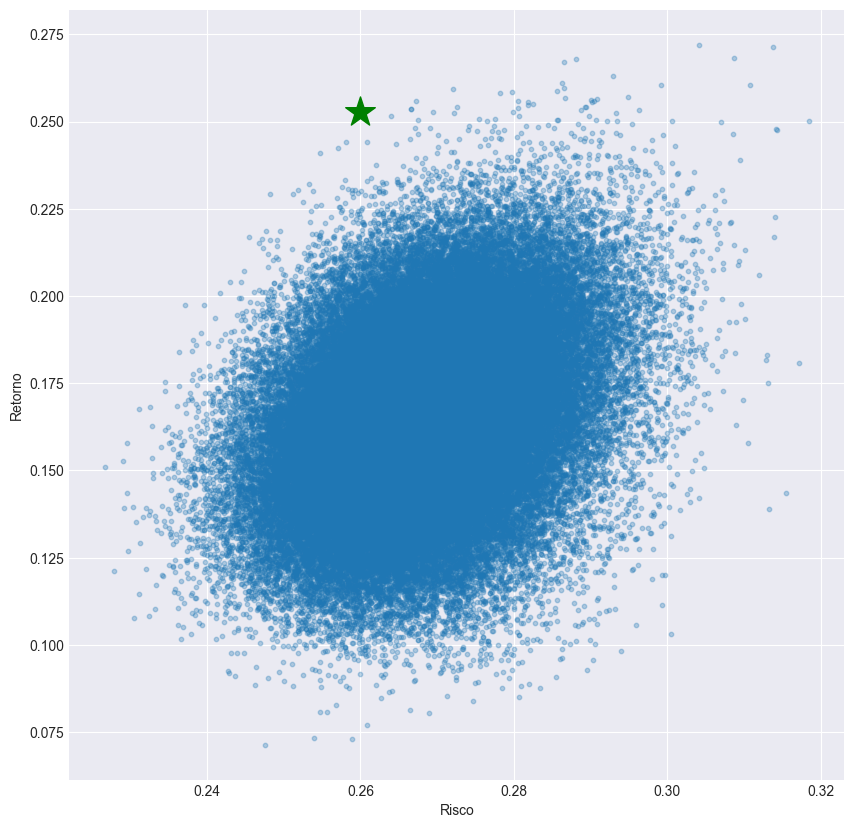

In [284]:
# Plotting optimal portfolio
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
#plt.scatter(portfolios['Volatility'], portfolios['Returns'],c=((portfolios['Returns']-rf)/portfolios['Volatility']), cmap = 'viridis', s=10, alpha=0.3)
#plt.scatter(min_vol_port[1], min_vol_port[0], color='purple', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)
plt.ylabel('Retorno')
plt.xlabel('Risco')
plt.show()

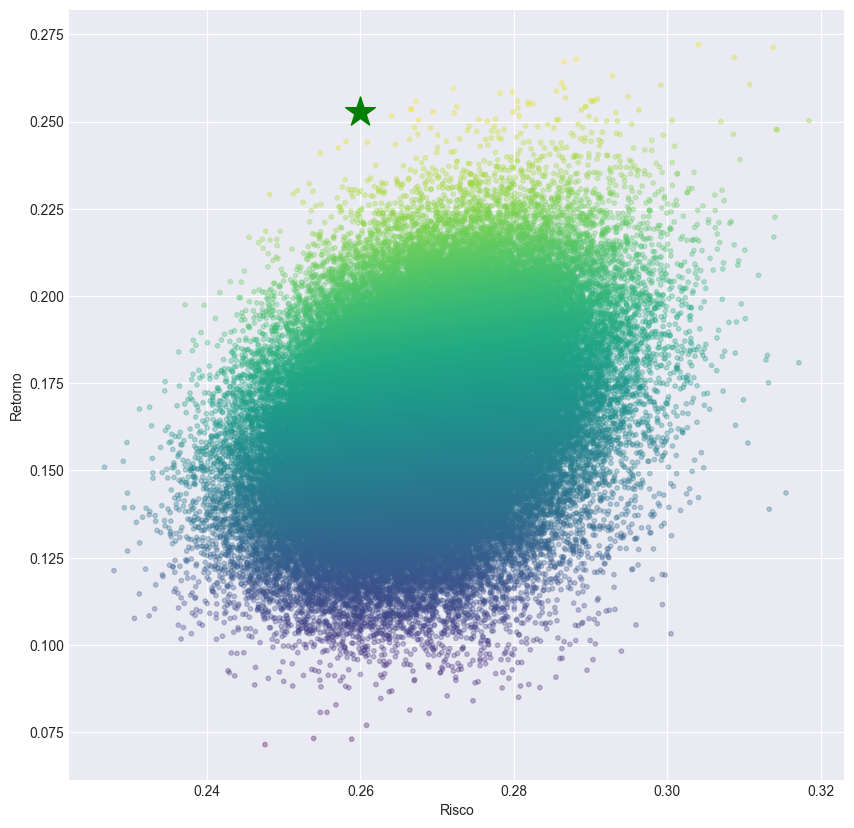

In [285]:
# Plotting optimal portfolio
plt.subplots(figsize=(10, 10))
# plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(portfolios['Volatility'], portfolios['Returns'],c=((portfolios['Returns']-rf)/portfolios['Volatility']), cmap = 'viridis', s=10, alpha=0.3)
#plt.scatter(min_vol_port[1], min_vol_port[0], color='purple', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)
plt.ylabel('Retorno')
plt.xlabel('Risco')
plt.show()

Codigos IA 1 
###

In [286]:
'''
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
df = df.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

df
'''

"\ndef calculate_returns(df):\n\n    outlier_cutoff = 0.005\n\n    lags = [1, 2, 3, 6, 9, 12]\n\n    for lag in lags:\n\n        df[f'return_{lag}m'] = (df['adj close']\n                              .pct_change(lag)\n                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),\n                                                     upper=x.quantile(1-outlier_cutoff)))\n                              .add(1)\n                              .pow(1/lag)\n                              .sub(1))\n    return df\n    \n    \ndf = df.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()\n\ndf\n"

In [287]:
#------------------ Libraries----------------------
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as spo
import tensorflow as tf
mlp.style.use('seaborn-v0_8-darkgrid')
# sns.set_theme(color_codes=True)

#--------------- Financial Data Class---------------

class FinancialData(object):

    '''This is a class stores information about financial data from ticker or 
    list of tickers, that can be prepared as a data frame and plotted.'''
    
    def __init__(self,tickers=['SPY'],fillna=True,cols=None,  **kwargs):
        """ Initiates the FinancialData object and takes the data from Yahoo 
        Finance from a set of tickers and prepares it in a dataframe.
        
        Inputs:
        -------
        tickers (list, default=['SPY']: list with the tickers of the assets
            analized.
        fillna (Boolean, default=True): determines whether to fill the NaNs in 
            the output dataframe with the financial information. They are filled
            forwards and then backwards.
        cols (list|strin, default=None): the columns of information you 
            want to extract.
        
        **kwargs: complementary arguments for the function yfinance.download(),
            you can see documentation in https://pypi.org/project/yfinance/
        
        Ouputs:
        -------
        None
        """
        # Prepare the data- Extract data from Yahoo Finance:
        if isinstance(tickers,list):
            t = ' '.join(tickers)
            df = yf.download(t, **kwargs)
        
        elif isinstance(tickers,str):
            df = yf.download(tickers,**kwargs)

        if not isinstance(cols,type(None)):
            df = df[cols]

        if fillna:
            df.fillna(method='ffill',inplace=True)
            df.fillna(method='bfill',inplace=True)

        # Rename columns so that they are one level:
        df = one_lvl_colnames(df,cols,tickers)

        # Define attributes:
        self.tickers = tickers
        self.df = df
        self.columns = cols
        
    def plot_data(self,tickers=None, cols='Adj Close',
                  title='Dado histórico de preço de fechamento adj',
                  ylabel='Preço de fechamento adj', 
                  xlabel='Data',
                  fontsize=15,
                  **kwargs):
        '''This method plots the data in the dataframe according to the column
         given assuming that the index of the dataframe is the x axis of the plot.

        Inputs:
        -------
        tickers (list|str, default=None): tickers wich will be plotted
        cols (string): if there are multiple columns still, select one to plot
        title (string, default="Historical Adj Close Price Data"): title for the
            plot.
        ylabel (string, default='Adj Close Prices'): y-label name for the plot.
        xlabel (string, default='Date'): x-label name for the plot.
        **kwargs: define the particularities of the plot, which must be arguments
            for the function DataFrame.plot() of Pandas.
        
        Ouputs:
        ------
        ax (axis): axis of the plot
        '''
        # Retrieve important information:
        df = self.get_data()
        if isinstance(tickers,type(None)):
            tickers = self.get_tickers()

        # Define data column, if multiple data is in the dataset:
        cols = return_names(cols,tickers)
        df = df[cols]

        # Define the axis, and plot the data:
        ax = df.plot(fontsize=fontsize,**kwargs)
        ax.set_title(title,fontsize=fontsize*1.3)
        ax.set_xlabel(xlabel,fontsize=fontsize*1.1)
        ax.set_ylabel(ylabel,fontsize=fontsize*1.1);

        return ax
    
    def rolling_statistics(self,cols='Adj Close',tickers=None,functions=None,
                      window=20,bollinger=False,roll_linewidth=1.5,**kwargs):
        '''This method extracts the rolling statistics from a time series, and
        can plot the rolling window with the data, adding the Bollinger bands.
        
        Inputs:
        -------
        column (string, default=None): the column from which you want compute 
            the rolling function.
        tickers (str|list, default=None): the ticker(s) from which you want to know the 
            information.
        functions (function|string|list): function(s) that will be rolled through the 
            time series.
        window (int): the window of the rolling data
            
        OUTPUTS:
            rolled (pandas series): a series with the rolling statistics specified

        '''
        # Define important varibles:
        df = self.df
        if isinstance(tickers,type(None)):
            tickers = self.get_tickers()
        col_names = return_names(cols,tickers)
        if isinstance(functions,type(None)):
            functions = [momentum, simple_moving_average, bollinger_bands]
        elif not isinstance(functions,list):
            functions = [functions]

        # Define the actual dataframe analized
        df = df[col_names]

        # Compute the rolling statistics:
        rolling_stats = df.rolling(window).agg(functions)

        # Given one level names:
        rolling_stats = one_lvl_colnames(rolling_stats,col_names,functions)

        return rolling_stats
    
    def get_returns(self,cols='Adj Close',tickers=None,return_window=1,plot=False,
                    **kwargs):
        '''This method finds the returns for a set of tickers'  prices
        Inputs:
        -------
        cols (list|string, default='Adj Close'): columns to find the returns.
        tickers (list|string, default=None): tickers from which the returns will be 
            computed.
        return_window (int, default=1): the window from which to get the returns.
        plot (boolean, default=False): determines whether to plot the returns or not.

        Outputs:
        --------
        returns (pandas series or data frame): pandas data structure with the 
            returns.
        '''
        # Define important variables:
        df = self.df
        if isinstance(tickers, type(None)):
            tickers = self.get_tickers()
        col_names = return_names(cols,tickers)
        
        # Compute the returns:
        returns = df[col_names].pct_change(return_window)

        # Plot returns:
        if plot:
            returns.plot(**kwargs)
        
        # Define attributes:
        self.returns = returns.dropna(how='all')
        self.return_window = return_window

        return self.returns
    
    def find_beta_alpha(self,market=None,plot=False,nrows=1,ncols=1,
                        figsize=(10,5), fillna=True,**kwargs):
        '''This method finds the beta and alpha of an stock in relation to the 
        market.

        Inputs:
        -------
        market (pandas Series): series with the returns data from the market portfolio
            asset with which to compute the beta and alpha. 
        plot (boolean, default=False): determines if a plot of the information is returned.
        nrows (int, default=1): the number of rows in the grid of plots.
        ncols (int, default=1): the number of columns in the grid of plots.
        figsize (tuple, default=(10,5)): the figure size of the plot.
        fillna (boolean, default=True): determines whether to fill NaN values after the merge
            with the market portfolio asset. It fills forwards first and then backwards.
        **kwargs: arguments that correspond to the plot.
        
        Outputs:
        --------
        alpha_beta (dictionary): dictionary where the key is the stock and the value is 
            a tuple of (alpha, beta) values for each stock.
        '''
        # Define important variables:
        #market = market.to_frame()
        market_name = market.columns[0]
        try:
            returns = self.returns
        except:
            returns = self.get_returns()
        
        # Merge data:
        df = market.merge(returns,left_index=True,right_index=True,how='left')

        # Fill NaNs
        if fillna:
            df.fillna(method='ffill',inplace=True)
            df.fillna(method='bfill',inplace=True)
        
        alpha_beta = {}
        stocks = [stock for stock in df.columns.values if stock != market_name]
        
        # Find the alpha, beta values for each stock in the object:
        for stock in stocks:
            beta, alpha = np.polyfit(df[market_name],df[stock],1)
            alpha_beta[stock] = (alpha,beta)
        if plot:
            fig = plt.figure(figsize=figsize)
            axs = {'ax'+str(i+1): fig.add_subplot(nrows,ncols,i+1) for i in range(len(stocks))}
            for i,stock in enumerate(stocks):
                alpha, beta = alpha_beta[stock]
                df.plot(kind='scatter',ax=axs['ax'+str(i+1)],
                                    x=market_name,y=stock,**kwargs)
                axs['ax'+str(i+1)].plot(df[market_name],df[market_name]*beta+alpha)
                axs['ax'+str(i+1)].text(
                    df[market_name].min(),
                    df[stock].max(),
                    # r'$\beta$ = {}  $\alpha$ = {}'.format(round(beta,2),round(alpha,2)),
                    r'$\beta$ = {}'.format(round(beta,2)),
                    fontsize=15
                    )

        return alpha_beta
    
    def get_normalized_prices(self, start_date=None,plot=False, prices_col='Adj Close',
                              title=None,x_label='Preço Fechamento',y_label='Preço normalizado',
                              fontsize=15,**kwargs):
        """Gives the normalized prices for the assets inside the FinancialData instance

        Inputs:
        -------
        start_data (str, default=None): the date which serves as the normalization point
            for the prices. If None, the method takes the earliest date in the prices
            data.
        plot (boolean, default=False): determines if plot normalized prices data.
        prices_col (string, default='Adj Close'): the name of the prices columns.
        **kwargs: addtitional arguments that go into the Dataframe.plot() method.
        
        Ouputs:
        -------

        norm_prices (pandas Dataframe): dataframe with normalized prices. The start_date 
            prices determine where is the 100 point for each asset.
        """
        # Define important variables:
        if not isinstance(prices_col,list):
            prices_col = [prices_col]
        prices_names = return_names(prices_col,self.get_tickers())
        prices = self.get_data()[prices_names]

        if isinstance(start_date,type(None)):
            start_date = prices.index.min()

        # Compute the normalized prices:
        base = prices.loc[prices.index==start_date].values
        norm_prices = prices/base*100

        # Plot normalized prices
        if plot:
            norm_prices.plot(fontsize=fontsize,**kwargs)
            
            # Plot 100-line:
            plt.hlines(
                y = 100,
                xmin = norm_prices.index.min(),
                xmax = norm_prices.index.max(),
                color = 'black',
                linestyles = 'dashdot')

            # Define title:
            if isinstance(title,type(None)):
                title = 'Preços Normalizados (100 = {}-{}-{})'.\
                        format(start_date.year,start_date.month,
                        start_date.day)
            
            plt.title(title,fontsize=fontsize*1.3)
            plt.ylabel(y_label,fontsize=fontsize*1.1)
            plt.xlabel(x_label,fontsize=fontsize*1.1)
            plt.show()

        return norm_prices

    def get_tickers(self):
        '''This method retreives the ticker attribute from the object instance
        '''
        return self.tickers

    def get_data(self):
        """This method retrieves the financial data"""
        return self.df


#---------------------- Portfolio Class--------------------------
class Portfolio(FinancialData):
    """This class contains the information of a portfolio, and inherits
    methods and attributes from the FinancialData class
    """

    def __init__(self,tickers=['SPY'],fillna=True,cols=None,weights=[1],
                 **kwargs):
        FinancialData.__init__(self,tickers,fillna,cols,**kwargs)
        #columns = [column+'_'+ticker for ticker in tickers]
        #prices = self.prepare_data(fillna=fillna)
        #self.prices = prices.loc[:,columns]
        self.weights = weights
    
    def normalize_prices(self,start_date=None,end_date=None,tickers=None,column='Close'):
        '''This method normalizes prices according to the dates provides, slicing the
        information from the start date to the end date
        INPUTS:
            prices (Pandas Data frame): dataframe with the time series of prices
            column (string): the information of the column to be normalized
            start_date (string): the start date, which serves as the normalization
                denominator
            end_date (string): the end date of the period to be analized
        
        OUTPUTS:
            norm_prices (Pandas Data frame): dataframe with the normalized price data
        '''
        prices = self.prices
        if tickers == None:
            tickers = self.get_tickers()
        if start_date is None:
            start_date = prices.index.values.min()
        if end_date is None:
            end_date = prices.index.values.max()
        columns = [column+'_'+ticker for ticker in tickers]
        norm_prices = prices.loc[start_date:end_date,columns]/prices.loc[start_date,columns]
        return norm_prices
    
    def get_portfolio_values(self,start_date=None,end_date=None,tickers=None,column='Close'):
        """This method returns the daily portfolio values
        INPUTS:
            prices (Pandas Data frame): dataframe with the time series of prices
            column (string): the information of the column to be normalized
            start_date (string): the start date, which serves as the normalization
                denominator
            end_date (string): the end date of the period to be analized
            weights (list): list of same length of tickers, with the weight of each 
                asset
            tickers (list): list with the tickers of the portfolio
        
        OUTPUTS:
            portfolio_values (pandas dataframe): dataframe with the daily values of the
                protfolio
        """
        prices = self.get_prices()
        weights = self.get_weights()
        if start_date == None:
            start_date = prices.index.values.min()
        if end_date == None:
            end_date = prices.index.values.max()
        if tickers == None:
            tickers = self.get_tickers()
        norm_prices = self.normalize_prices(start_date,end_date,tickers,column)
        portfolio_values = norm_prices*weights
        portfolio_values['Portfolio'] = portfolio_values.sum(axis=1)
        return portfolio_values

    def get_prices(self):
        """This method returns the prices attribute of the Portfolio instance
        """
        return self.prices
    
    def get_weights(self):
        """This method returns the weights of the Portfolio instance"""
        return self.weights
    
    def change_weights(self,weights):
        """This method changes the weights attribute of the Portfolio instance
        INPUTS:
            weights (list): list with new weights.
        
        OUTPUTS:
            None
        """
        assert len(self.weights) == len(weights), "Wrong length of weights"
        self.weights = weights
    
    def get_returns(self,start_date=None,end_date=None,tickers=None,
                    column='Close',window=1,portfolio_returns=False):
        """This method returns the daily returns of the Portfolio instance
        Inputs:
        -------
        prices (Pandas Data frame): dataframe with the time series of prices
        column (string): the information of the column to be normalized
        start_date (string): the start date, which serves as the normalization
            denominator
        end_date (string): the end date of the period to be analized
        weights (list): list of same length of tickers, with the weight of each 
            asset
        tickers (list): list with the tickers of the portfolio
        window (int): the window of the returns, default daily
        
        Outputs:
        -------
        portfolio_values (pandas dataframe): dataframe with the daily values of the
            protfolio
        """

        # Get the returns of each asset inside the portfolio:
        prices = self.get_prices()
        if start_date is None:
            start_date = prices.index.values.min()
        if end_date is None:
            end_date = prices.index.values.max()
        if tickers is None:
            tickers = self.get_tickers()
        columns = [column+'_'+ticker for ticker in tickers]
        prices = prices.loc[start_date:end_date,columns]
        returns = prices.pct_change(window).dropna(how='all')

        # Add the portfolio returns
        if portfolio_returns:
            weights = self.get_weights()
            returns['Portfolio'] = (returns*weights).sum(axis=1)

        return returns
    
    def get_performance_metrics(self,risk_free_rate=0,start_date=None,
                                end_date=None,**kwargs):
        """This method computes the cumulative return, the average daily 
        return, the risk (the standard deviation) and the Sharpe Ratio of the
        Portfolio instance

        Inputs:
        ------
        risk_free_rate: the risk free rate of the market, which can be a 
            constant or a series of the same length as the returns series
        
        Outputs:
        -------
         metrics (pandas Data Frame): the metrics of the portfolio
        """
        if start_date == None:
            start_date = self.get_prices().index.values.min()
        if end_date == None:
            end_date = self.get_prices().index.values.max()
        portfolio_values = self.get_portfolio_values(start_date,end_date,
                                                    **kwargs)
        def compute_cum_return(series):
            """Computes the cumulative return of a series"""
            mn = series.index.values.min()
            mx = series.index.values.max()
            cum_return = (series[mx]/series[mn])-1
            return cum_return  

        cum_return = compute_cum_return(portfolio_values['Portfolio'])
        returns = self.get_returns(start_date,end_date,
                                   portfolio_returns=True,**kwargs)
        sharpe_ratio = self.get_sharpe_ratio(risk_free_rate,start_date=start_date,
                                             end_date=end_date,**kwargs)
        metrics = returns['Portfolio'].agg(['mean','std'])
        metrics.loc['Cum Return'] = cum_return
        metrics.loc['Sharpe Ratio'] = sharpe_ratio
        return metrics

    def get_sharpe_ratio(self,weights=None,rfr=0,negative=False,**kwargs):
        """Compute the Sharpe Ratio of a portfolio
        Inputs:
        -------
        rfr (numeric value or Pandas series): the risk free rate of 
            the market, which can be a constant value or a series of the same
            length than the returns of the Portfolio, with corresponding dates.
        negative (boolean): True if you want to multiply the Sharpe Ratio by -1
            this is used for optimizing the portfolio. Default False.
        **kwargs: arguments for the get_returns method
        Ouputs:
        -------
        sharpe_ratio (numeric value): the Sharpe Ratio of the portfolio given the
            characteristics of the Portfoliol instance.
        """
        # Get building blocks for the computation:
        returns = self.get_returns(**kwargs)
        if weights is None:
            weights = self.get_weights()

        # Get the portfolio returns:
        portfolio_returns = (returns*weights).sum(axis=1)
        portfolio_std = portfolio_returns.std()

        # Compute Sharpe Ratio formula:
        sharpe_ratio = (portfolio_returns-rfr).mean()/portfolio_std
        if negative:
            sharpe_ratio *= -1
        return sharpe_ratio

    def optimize_portfolio(self,guess_weights=None,short=False,rfr=0,**kwargs):
        """Optimizes the weights of the assets that compose the portfolio, such
        that it maximizes the Sharpe Ratio of the portfolio.
        Inputs:
        -------
        guess_weights (list,tuple, array): an array-like object with the length
            of the number of assets composing the portfolio, which will be used
            to start the optimization process
        rfr (numerical value): risk-free rate of the market, can be a series or
            a constant.
        **kwargs: arguments to be used in the get_returns method

        Outputs:
        --------
        opt_weights (array-like): array-like object with the weights that maximize
            the Sharpe Ratio of the portfolio.
        """
        tickers = self.get_tickers()

        if guess_weights is None:
            guess_weights = [1/len(tickers) for i in range(len(tickers))]
        
        # Determine the bounds of the optimized weights (min=0, max=1):
        if not short:
            bounds = [(0,1) for i in range(len(tickers))]
        else:
            bounds = [(-1,1) for i in range(len(tickers))]

        # Determine the restrictions:
        weights_sum_to_1 = {'type':'eq',
                            'fun':lambda weights: np.sum(np.absolute( weights))-1}
        
        # Optimize:
        opt_weights = spo.minimize(
            self.get_sharpe_ratio,guess_weights,
            args=(rfr,True),
            method='SLSQP', options={'disp':False},
            constraints=(weights_sum_to_1),
            bounds=bounds
        )

        # Update weights to optimized weights
        print(len(opt_weights.x))
        self.change_weights(opt_weights.x)

        return opt_weights.x

#-----------------------------WindowGenerator Class-------------------------------------
# This class was done using the guidance of the TensorFlow tutorial found in:
# https://www.tensorflow.org/tutorials/structured_data/time_series

class WindowGenerator():
    """This class takes time series data that is in a sequential format, transforming
    it into pairs of inputs and labels, so that the inputs are windows of consecutive
    samples from the data.
    """
    def __init__(self,input_width=5,label_width=1,shift=1, train_df=None, val_df=None,
                 test_df=None, label_columns=None,batch_size=None,shuffle=False):
        """This method initiates the WindowGenerator class.

        Inputs:
        -------
        input_width (int, default=5): the width of the window, which represents the 
            amount of time steps from the earliest input observation to the last.
        label_width (int, default=1): the width of the label. This determines the amount
             of time steps that will be predicted.
        shift (int, default=1): jump between the last input in the window and the first 
            label.
        train_df (pandas Dataframe, default=None): array-like object containing the train 
            data which comes in a time series format.
        val_df (pandas Dataframe, default=None): array-like object containing the 
            validation data.
        test_df (pandas Dataframe, default=None): array-like object containing the test 
            data.
        label_columns (list|string, default=None): name of the column(s) that are used 
            as labels.
        batch_size (int, deafault=None): the size of the batches of the tf.data.Dataset
            object (whose dimensions are (batch,input_width,features) for the input and
            (batch,label_width,label_columns) for the labels).
        shuffle (boolean, default=False): determines if the data inside the tf.data.Dataset
            is shuffled.
        
        Outputs:
        --------
        None
        """
        # Define attributes of the class:
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label_columns = label_columns
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Define information about columns:
        if isinstance(label_columns,type(None)):
            self.label_columns_indices = {name:i for i,name in enumerate(label_columns)}
        self.column_indices = {name:i for i,name in enumerate(train_df.columns)}

        # Define window information:
        self.total_window_size = input_width+shift
        self.input_slice = slice(0,input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size-self.label_width
        self.labels_slice = slice(self.label_start,None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        """This method determines what is returned when an instance of the object
        is called
        """
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        """This method converts a list of consecutive inputs to a window of
        inputs and a window of labels.

        Inputs:
        -------
        features (pandas Dataset): features in the dataframe

        Outputs:
        --------
        inputs ()
        """
        inputs = features[:, self.input_slice,:]
        labels = features[:,self.labels_slice,:]
        if not isinstance(self.label_columns,type(None)):
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis = -1
            )
        
        # Set the shapes of the informaiton:
        inputs.set_shape([None,self.input_width,None])
        labels.set_shape([None,self.label_width,None])

        return inputs,labels
    
    def make_dataset(self,data):
        """This method takes a time series DataFrame and convert it to a 
        tf.data.Dataset of (input_window,label_window) pairs, using the
        tf.keras.preprocessing.timeseries_dataset_from_array function.

        Input:
        ------
        data (pandas DataFrame): dataframe containing the time series information
            of the inputs and labels, which will transformed into windows and then 
            a tf.Dataset object.
        
        Outputs:
        --------

        """
        data = np.array(data,dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data = data,
            targets = None,
            sequence_length = self.total_window_size,
            sequence_stride = 1,
            shuffle = self.shuffle,
            batch_size = self.batch_size
        )
        ds = ds.map(self.split_window)

        return ds

    # Adding properties for accessing the train, val and test as tf.data.Dataset objects
    @property
    def train(self):
        if isinstance(self.train_df,type(None)):
            return None
        else:
            return self.make_dataset(self.train_df)

    @property
    def val(self):
        if isinstance(self.val_df,type(None)):
            return None
        else:
            return self.make_dataset(self.val_df)

    @property
    def test(self):
        if isinstance(self.test_df,type(None)):
            return None
        else:
            return self.make_dataset(self.test_df)
    
#---------------------------------------------------------------------------------------
# 3. Complementary functions:

def one_lvl_colnames(df,cols,tickers):
    """This function changes a multi-level column indexation into a one level
    column indexation

    Inputs:
    -------
    df (pandas Dataframe): dataframe with the columns whose indexation will be 
        flattened.
    tickers (list|string): list/string with the tickers (s) in the data frame df.
    cols (list|string): list/string with the name of the columns (e.g. 'Adj Close',
        'High', 'Close', etc.) that are in the dataframe df.
    
    Ouputs:
    -------
    df (pandas Dataframe): dataframe with the same information as df, but 
        with one level of indexation.
    """
    # Define important variables:
    if isinstance(tickers, str):
        tickers = [tickers]
    if isinstance(cols, str):
        cols = [cols]

    # For multi-level column indexing:
    if isinstance(df.columns.values[0], tuple):

        # Define important varibles
        columns = df.columns.values
        new_cols = []

        # Itarate through the multi-level column names and flatten them:
        for col in columns:
            temp = []
            for name in col:
                if name != '':
                    temp.append(name)
            new_temp = '_'.join(temp)
            new_cols.append(new_temp)
        
        # Change the column names:
        df.columns = new_cols
    
    # For uni-level colum indexing:
    elif isinstance(df.columns.values[0], str):
        
        # Define new names:
        col_names = [column+'_'+ticker for column in cols\
                     for ticker in tickers]
        df.columns = col_names

    return df

def return_names(cols,tickers):
    """This function takes ticker(s) and column(s) and defines the names
    of the combination of both.

    Inputs:
    -------
    cols (list|string): column names (e.g. 'Adj Close', 'Close', 'High').
    tickers (list|string): ticker names.
    
    Outputs:
    --------
    col_names (list): names of the columns for the given cols and tickers
    """
    # Give the correct type:
    if isinstance(cols, str):
        cols = [cols]
    if isinstance(tickers, str):
        tickers = [tickers]

    col_names = [col+'_'+ticker for col in cols for ticker in tickers]

    return col_names

def momentum(prices):
    """This function finds the momentum metric for a group of assets.
    Inputs:
    -------
    prices (pandas dataframe|series): dataframe with the information of the
        prices of a group of assets or an indivitual asset.
    
    Outputs:
    --------
    momentum_df (pandas Dataframe): dataframe with the information of the
        momentum.
    """
    # Compute components:
    first = prices.iloc[0]
    last = prices.iloc[-1]

    # Compute momentum:
    momentum_df = last/first

    return momentum_df

def simple_moving_average(prices):
    """This function computes the simple moving average for a set of prices
    given a time window.

    Inputs:
    -------
    prices (pandas Dataframe|Series): dataframe with the information of the
        prices of the analyzed assets.

    Outputs:
    --------
    sma (pandas Dataframe): dataframe of the SMA of the assets' prices in
        the prices dataframe.
    """
    # Compute the SMA of the assets:
    mean = prices.mean()
    sma = prices[-1]/mean-1

    return sma
    
def bollinger_bands(prices):
    """This function computes the bollinger bands values for a set of assets
    returned in a pandas dataframe.

    Inputs:
    -------
    prices (pandas Dataframe|Series): dataframe with the price infromation
        of the assets analyzed.
    window (numeric value, default=None): determines if compute the BBs in
        a rolling manner, or if compute them to the whole input of prices.
    
    Outputs:
    --------
    bb (pandas dataframe): dataframe with the information of the bollinger
        bands of the assets in the prices dataframe.
    """
    # Compute components:
    ma = prices.mean()
    std = prices.std()

    # Compute bollinger bands:
    bb = (prices[-1]-ma)/(2*std)

    return bb

def plot_window(window_dataset,pandas_dataset,window_size,model,
                figsize=(12,100)):
    """This function plots the observed returns inside a tf.data.Dataset and
    compares them with the predicted returns of a model.

    Inputs:
    -------
    window_dataset (tensorflow.data.Dataset object): dataset with both inputs
        and target values.
    pandas_dataset (pandas DataFrame): dataframe that was used to create the
        window_dataset.
    window_size (int): window size used in the transformation from sequential 
        time series into window time series.
    model (model object): trained model with the capability to predict in a
        similar manner than tensorflow.keras.Model object.
    figsize (tuple, default=(12,100)): tuple with the dimensions of the figure
        where the data will be plotted.
    
    Ouputs:
    -------
    None
    """
    # Determine the X-axis of the plot:
    plot_index = pandas_dataset.iloc[window_size:,:].index

    # Assign in the addecuate format the values of the observed taget variable(s):
    y = np.concatenate([targets for inputs,targets in window_dataset],axis=0)
    
    # Use the model to predict the target variable(s):
    y_hat = model.predict(window_dataset)

    # Adjust the shapes:
    y = y.reshape(y_hat.shape)

    # Plot the data:
    plt.figure(figsize=figsize)
    for n in range(y_hat.shape[1]):
        plt.subplot(y_hat.shape[1],1,n+1)
        plt.ylabel('Retorno')
        plt.plot(plot_index,y_hat[:,n],label='Predição',color='maroon')
        plt.plot(plot_index,y[:,n],label='Observado',color='midnightblue',alpha=0.5)
    plt.legend()    
    plt.show()

def daily_rate(x, periods_year=252):
    """This function transforms a rate into a daily rate

    Inputs:
    -------
    x (numerical value): rate that you want to transform into a daily rate.
    periods_year (numerical value, default=252): amount of periods per year
        of the periodicity of rate x.
    
    Ouputs:
    -------
    df (numerical value): daily rate
    """
    dr = np.power(1+x,1/periods_year)-1
    return dr

def optimize_portfolio(returns,guess_weights=None,short=True,rfr=0):
    """This function optimizes the weight allocation for the assets in a
    portfolio, represented by the returns.

    Inputs:
    -------
    returns (pandas DataFrame|Series): contains the returns information.
    guess_weights (list of numerical values, default=None): guess values for
        the weights of the different assets in the portfolio.
    short (boolena, default=True): define ifshort possitions are allowed or 
        not.
    rfr (numerical value, default=0): risk free rate, could be a series of
        the same length as returns.

    Outputs:
    --------
    opt_weights (array-like object): array with the optimal weights for the
        portfolio.
    """
    # Define important variables:
    num_assets = returns.shape[1]
    if isinstance(guess_weights,type(None)):
        guess_weights = [1/num_assets for i in range(num_assets)]

    # Define bound if short possitions are allowed or not:
    if not short:
        bounds = [(0,1) for i in range(num_assets)]
    else:
        bounds = [(-1,1) for i in range(num_assets)]

    # Define constraints, if there can or not be leverage
    weights_sum_to_1 = {'type':'eq',
                        'fun':lambda weights: np.sum(np.absolute(weights))-1}
    
    # Minimize the function:
    opt_weights = spo.minimize(
        sharpe_ratio,
        guess_weights,
        args = (rfr, True, returns),
        method = 'SLSQP',
        options = {'disp':False},
        constraints = (weights_sum_to_1),
        bounds = bounds
    )

    return opt_weights 

def sharpe_ratio(weights=None, rfr=0, negative=False, returns=0):
    """Compute the Sharpe Ratio of a portfolio.

    Inputs:
    -------
    weights (list of numerical values, default=None): list with the weights
        of the assets in the portfolio.
    rfr (numerical value|array-like, default=0): risk-free rate.
    returns (pandas DataFrame|Series, default=0): returns of the assets in
        the portfolio.

    Outputs:
    --------
    sharpe_ratio (numerical value): Sharpe ratio of the portfolio.
    """
    # Define important variables:
    num_assets = returns.shape[1]
    if isinstance(weights,type(None)):
        weights = [1/num_assets for i in range(num_assets)]

    # Get portfolio returns:
    portfolio_returns = (returns*weights).sum(axis=1)
    portfolio_std = portfolio_returns.std()

    # Compute Sharpe Ratio formula:
    sharpe_ratio = (portfolio_returns-rfr).mean()/portfolio_std

    # If used in a minization process:
    if negative:
        sharpe_ratio *= -1

    return sharpe_ratio    

In [288]:
n_stocks = len(tickers)
n_stocks

15

In [289]:
my_portfolio = FinancialData(
    tickers = tickers,
    cols = ['Adj Close','Volume'],
    start = start_date,
    end = end_date)
my_portfolio.plot_data(figsize=(13,8),fontsize=15)
plt.show()

[*********************100%***********************]  15 of 15 completed


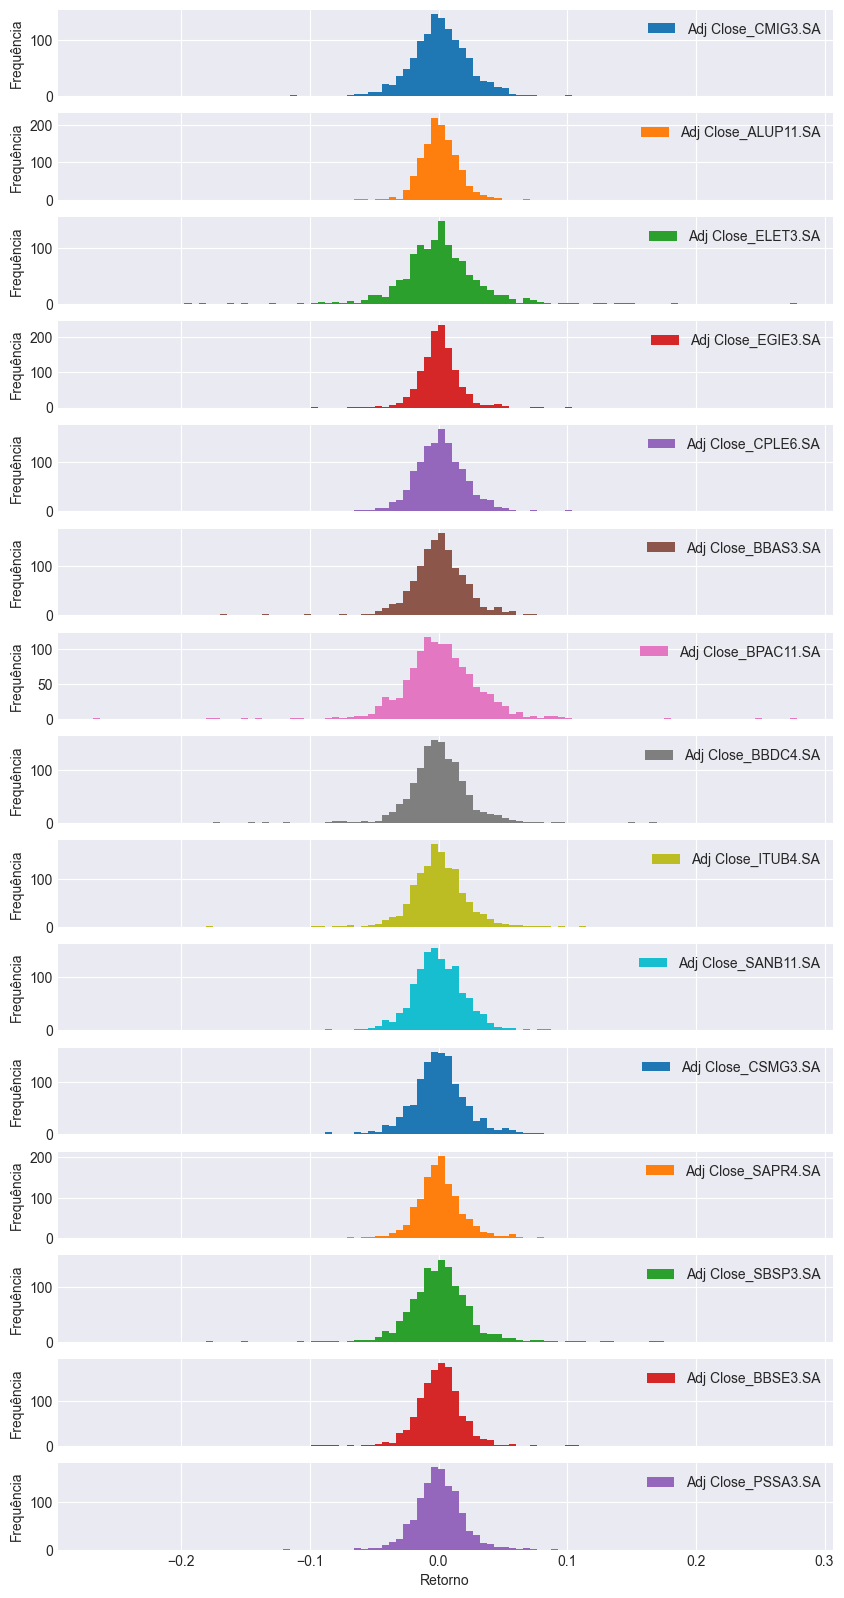

In [290]:
port_returns = my_portfolio.get_returns(plot=True,subplots=True,figsize=(10,20),kind='hist',bins=100, ylabel='Frequência',xlabel='Retorno')
plt.show()

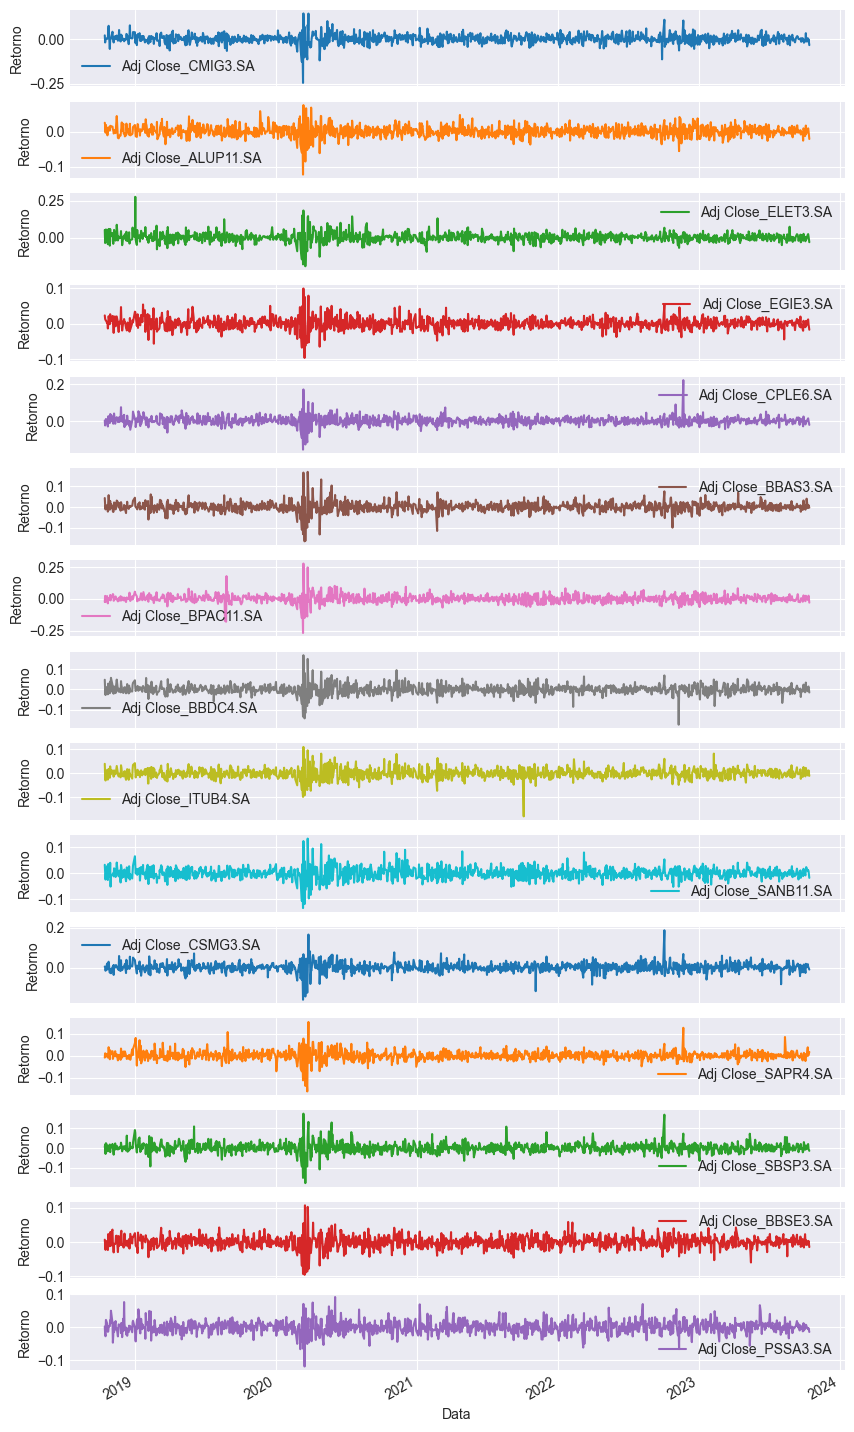

In [291]:
port_returns = my_portfolio.get_returns(plot=True,subplots=True,figsize=(10,20), ylabel='Retorno',xlabel='Data')
plt.show()

[*********************100%***********************]  1 of 1 completed

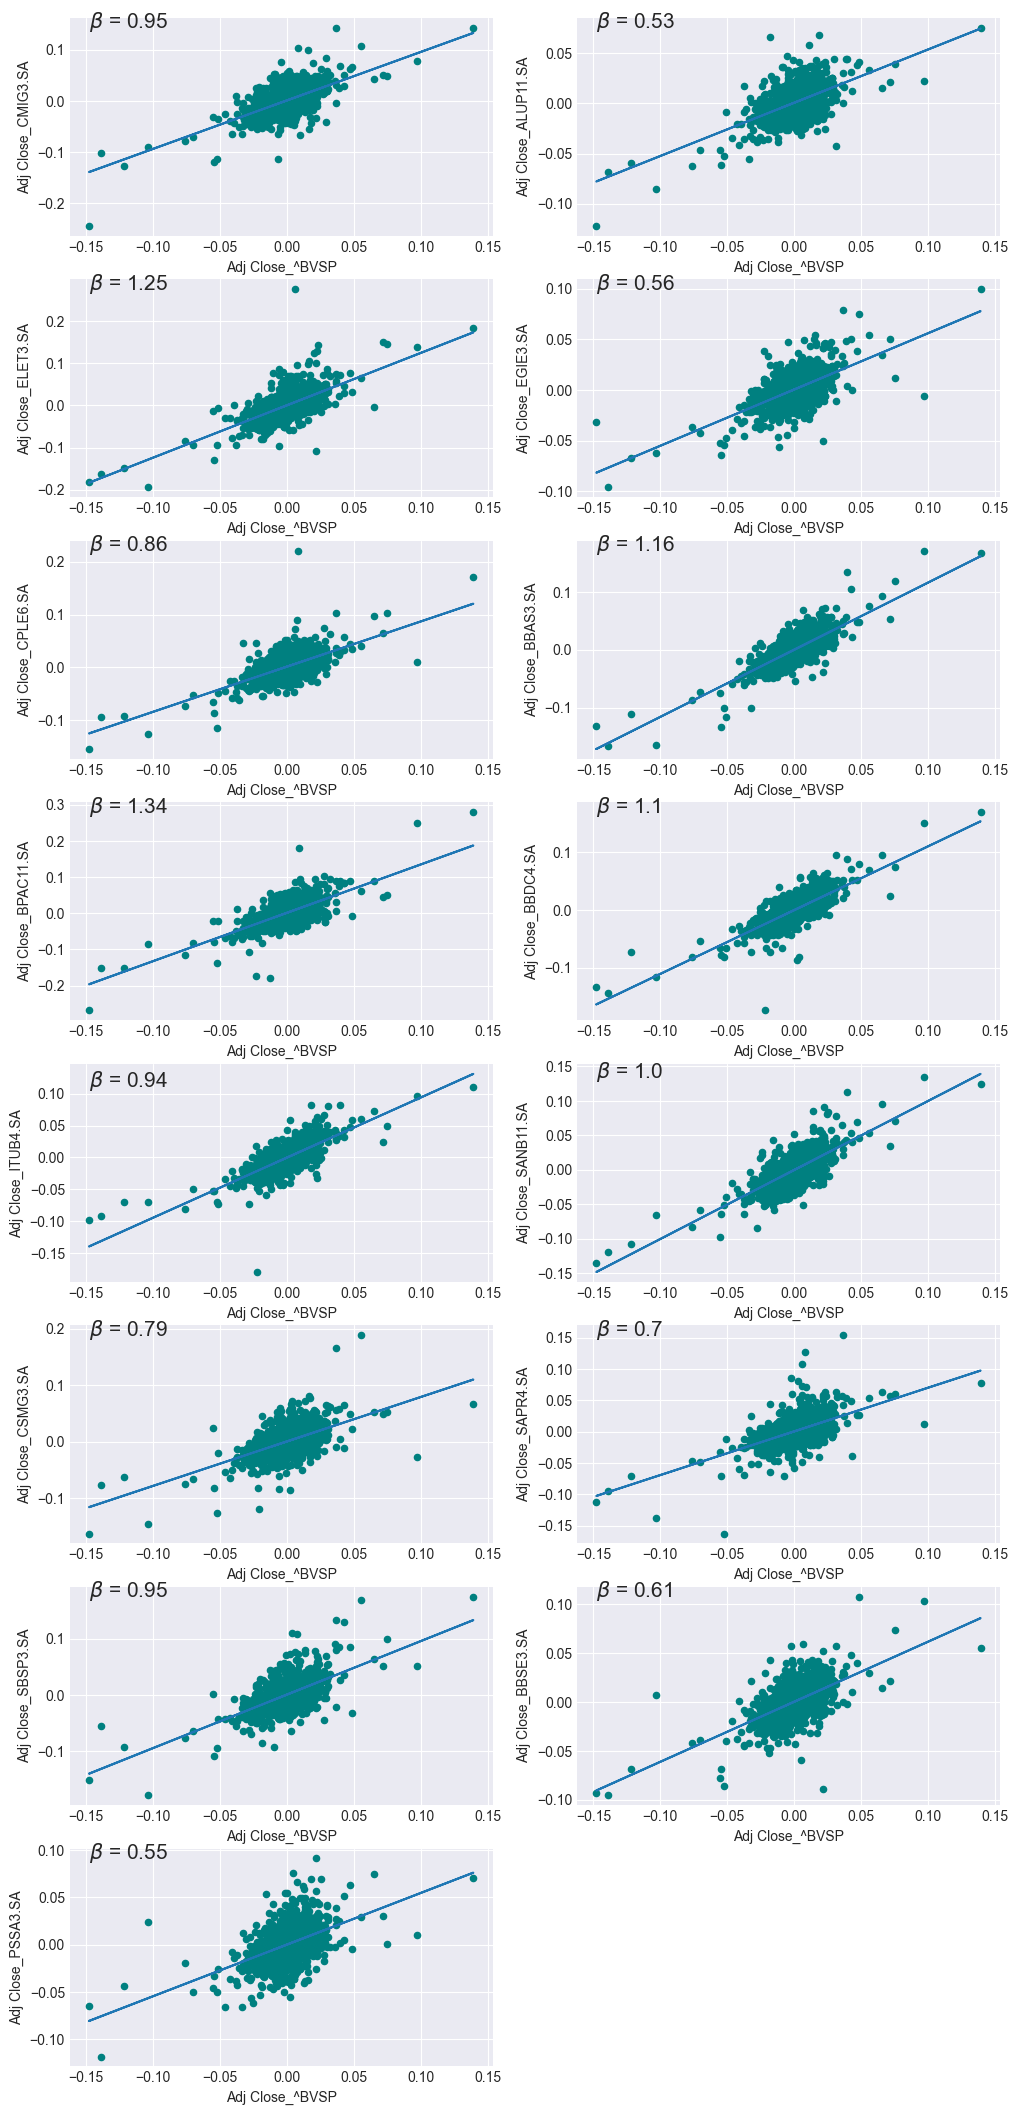

In [292]:
market = yf.download("^BVSP",start=start_date,end=end_date)['Adj Close'].rename(columns={"^BVSP": "Adj Close_^BVSP"}).pct_change() #.to_frame()
#market = one_lvl_colnames(df=market,cols = 'Adj Close',tickers="^BVSP").squeeze(axis=0)
market
#df.unstack('ticker')['adj close']

#unstack('ticker')['adj close']
# .tz_localize(None)
portfolio_alphas_betas = my_portfolio.find_beta_alpha(market=market,plot=True,nrows=9,ncols=2,figsize=(12,30),color='teal')

plt.show()

In [293]:
norm_prices =my_portfolio.get_normalized_prices(plot=True,figsize=(13,8),fontsize=15)
plt.show()

In [294]:
def abs_mean(x):
    """Computes the mean of the absolute values of x
    Inputs:
    -------
    x (pandas DataFrame|Series)
    
    Outputs:
    --------
    ab_m (numerical value): the mean of the absolute values of x
    """
    
    ab = x.abs()
    ab_m = ab.mean()
    return ab_m
    
port_returns.agg(['min','max','mean','std','kurtosis','skew',abs_mean]).transpose()

min       max      mean       std   kurtosis  \
Adj Close_CMIG3.SA  -0.244082  0.142549  0.001409  0.025226  10.543207   
Adj Close_ALUP11.SA -0.122088  0.075023  0.000772  0.015444   5.618638   
Adj Close_ELET3.SA  -0.195051  0.276245  0.001049  0.031436  10.192692   
Adj Close_EGIE3.SA  -0.096285  0.099224  0.000663  0.015497   4.716158   
Adj Close_CPLE6.SA  -0.154991  0.220670  0.001594  0.022859  13.002920   
Adj Close_BBAS3.SA  -0.166895  0.171261  0.000784  0.024446  10.417335   
Adj Close_BPAC11.SA -0.268633  0.278941  0.002068  0.032193  13.789412   
Adj Close_BBDC4.SA  -0.173843  0.168669  0.000224  0.023619   8.621804   
Adj Close_ITUB4.SA  -0.179643  0.110593  0.000247  0.020904   6.650238   
Adj Close_SANB11.SA -0.134740  0.134101  0.000236  0.022452   5.095281   
Adj Close_CSMG3.SA  -0.162745  0.187879  0.000603  0.023650   9.447814   
Adj Close_SAPR4.SA  -0.162579  0.153666  0.000798  0.020974   9.772174   
Adj Close_SBSP3.SA  -0.178300  0.174603  0.001067  0.025583   8.193382   
Adj Close_BBSE3.SA  -0.095077  0.107558  0.000627  0.017626   4.709957   
Adj Close_PSSA3.SA  -0.118087  0.091099  0.000382  0.018811   2.827703   

                         skew  abs_mean  
Adj Close_CMIG3.SA  -0.671141  0.017740  
Adj Close_ALUP11.SA -0.437316  0.011234  
Adj Close_ELET3.SA   0.549431  0.021204  
Adj Close_EGIE3.SA   0.129985  0.011033  
Adj Close_CPLE6.SA   0.656137  0.015820  
Adj Close_BBAS3.SA  -0.110397  0.016407  
Adj Close_BPAC11.SA  0.135433  0.021960  
Adj Close_BBDC4.SA  -0.144865  0.016351  
Adj Close_ITUB4.SA  -0.343758  0.015090  
Adj Close_SANB11.SA  0.174784  0.016242  
Adj Close_CSMG3.SA   0.020266  0.016233  
Adj Close_SAPR4.SA   0.079426  0.014064  
Adj Close_SBSP3.SA   0.396943  0.017639  
Adj Close_BBSE3.SA  -0.158733  0.012803  
Adj Close_PSSA3.SA   0.096096  0.013921

In [295]:
names = ['selic']

str_start_date = start_date.strftime('%d/%m/%Y')
str_end_date = str(end_date.split("-")[2])+"/"+ str(end_date.split("-")[1])+"/"+ str(end_date.split("-")[0])
url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial="+str_start_date+"&dataFinal="+str_end_date
df_extra = pd.read_json(url)



#["-".join(x) for x in ([x[::-1] for x in ([x.split('/') for x in df_extra['data']])])]
df_extra['data'] = [pd.Timestamp("-".join(x)) for x in ([x[::-1] for x in ([x.split('/') for x in df_extra['data']])])]
#df_extra['data']
df_extra.columns= ['Date', 'valor']

add_factors =  pd.DataFrame({'selic': list(df_extra['valor'])},
                   index=df_extra['Date'])

# add_factors.fillna(method='ffill',inplace=True)
# add_factors.fillna(method='bfill',inplace=True)

#df_extra['data'].str.split("/").to_string()
add_factors


selic
Date                
2018-10-15  0.024620
2018-10-16  0.024620
2018-10-17  0.024620
2018-10-18  0.024620
2018-10-19  0.024620
...              ...
2023-10-06  0.047279
2023-10-09  0.047279
2023-10-10  0.047279
2023-10-11  0.047279
2023-10-13  0.047279

[1256 rows x 1 columns]

In [296]:
#IMA-B

#https://api.bcb.gov.br/dados/serie/bcdata.sgs.12466/dados?formato=json&dataInicial=01/01/2020&dataFinal=31/12/2020
url2 = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.12466/dados?formato=json&dataInicial="+str_start_date+"&dataFinal="+str_end_date
df_extra2 = pd.read_json(url2)
df_extra2['data'] = [pd.Timestamp("-".join(x)) for x in ([x[::-1] for x in ([x.split('/') for x in df_extra2['data']])])]
df_extra2.columns= ['Date', 'valor']
add_factors2 =  pd.DataFrame({'imab': list(df_extra2['valor'])},
                   index=df_extra2['Date'])


add_factors2.fillna(method='ffill',inplace=True)
add_factors2.fillna(method='bfill',inplace=True)
add_factors2



imab
Date                   
2018-10-15  5945.484806
2018-10-16  5983.605691
2018-10-17  6016.573361
2018-10-18  5993.827983
2018-10-19  5991.675059
...                 ...
2023-05-16  9213.440940
2023-05-17  9213.802638
2023-05-18  9205.759195
2023-05-19  9213.470092
2023-05-22  9196.683762

[1153 rows x 1 columns]

In [297]:
add_factors3 = yf.download("USDBRL=X",start=start_date,end=end_date)['Adj Close'].rename(columns={"^BVSP": "Adj Close_^BVSP"}).pct_change()
add_factors3.fillna(method='ffill',inplace=True)
add_factors3.fillna(method='bfill',inplace=True)
add_factors3

[*********************100%***********************]  1 of 1 completed


Ticker                     USDBRL=X
Date                               
2018-10-15 00:00:00+00:00 -0.012614
2018-10-16 00:00:00+00:00 -0.012614
2018-10-17 00:00:00+00:00 -0.002759
2018-10-18 00:00:00+00:00 -0.010044
2018-10-19 00:00:00+00:00  0.009251
...                             ...
2023-10-09 00:00:00+00:00 -0.003737
2023-10-10 00:00:00+00:00 -0.002041
2023-10-11 00:00:00+00:00 -0.016397
2023-10-12 00:00:00+00:00 -0.000277
2023-10-13 00:00:00+00:00 -0.000733

[1304 rows x 1 columns]

In [298]:
'''
names = ['selic']

str_start_date = start_date.strftime('%d/%m/%Y')
str_end_date = str(end_date.split("-")[2])+"/"+ str(end_date.split("-")[1])+"/"+ str(end_date.split("-")[0])
url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial="+str_start_date+"&dataFinal="+str_end_date
df_extra = pd.read_json(url)
df_extra

add_factors =  pd.DataFrame({'selic': list(df_extra['valor'])},
                   index=df_extra['data'])

# Fill NaN values:
add_factors.fillna(method='ffill',inplace=True)
add_factors.fillna(method='bfill',inplace=True)
'''

'''
# Extracting additional factors:
new_tickers = ['EIA/PET_RWTC_D','FRED/T10Y2Y','FRED/T10Y3M','FRED/DTB3','FRED/DLTIIT',
               'FRED/TEDRATE']
names = ['wti_spot','10y2y_spread','10y3m_spread','3m_rate','ltiit','ted_spread']
add_factors = quandl.get(new_tickers, start_date=start_date, end_date=end_date,
                       api_key=quandl.ApiConfig.api_key)
add_factors.columns = names
add_factors['var_wti'] = add_factors['wti_spot'].pct_change()

# Fill NaN values:
add_factors.fillna(method='ffill',inplace=True)
add_factors.fillna(method='bfill',inplace=True)
'''

# Factors: momentum, simple moving average and bollinger bands:
factors = my_portfolio.rolling_statistics()
type(factors.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [299]:
# # Merge dataframes to get the full data for modeling:
# total_df = port_returns.merge(factors,right_index=True,left_index=True,how='left')
# total_df = total_df.merge(add_factors,right_index=True,left_index=True,how='left')
total_df = port_returns.tz_localize(None).merge(factors.tz_localize(None),right_index=True,left_index=True,how='left')
total_df = total_df.tz_localize(None).merge(add_factors.tz_localize(None),right_index=True,left_index=True,how='left')
# total_df = total_df.tz_localize(None).merge(add_factors2.tz_localize(None),right_index=True,left_index=True,how='left')
# total_df = total_df.tz_localize(None).merge(add_factors3.tz_localize(None),right_index=True,left_index=True,how='left')
total_df.dropna(subset=factors.columns,inplace=True)
total_df

Adj Close_CMIG3.SA  Adj Close_ALUP11.SA  Adj Close_ELET3.SA  \
Date                                                                      
2018-11-12            0.015693             0.004444            0.000000   
2018-11-13            0.000000            -0.004425           -0.020728   
2018-11-14            0.000000             0.011111           -0.006047   
2018-11-16            0.019743             0.043956            0.086484   
2018-11-19           -0.009260            -0.017895           -0.020000   
...                        ...                  ...                 ...   
2023-10-06           -0.013123             0.001757           -0.003436   
2023-10-09            0.004787             0.003157            0.018678   
2023-10-10           -0.013764             0.009091            0.023131   
2023-10-11           -0.001073             0.001039            0.007168   
2023-10-13           -0.033853            -0.021115           -0.031755   

            Adj Close_EGIE3.SA  Adj Close_CPLE6.SA  Adj Close_BBAS3.SA  \
Date                                                                     
2018-11-12            0.010742           -0.014952            0.016386   
2018-11-13           -0.007178            0.005421           -0.011380   
2018-11-14            0.020444            0.010065            0.001679   
2018-11-16            0.020279            0.020640            0.031601   
2018-11-19            0.003352           -0.005927            0.023440   
...                        ...                 ...                 ...   
2023-10-06           -0.001718           -0.001198            0.040690   
2023-10-09            0.010330            0.009592           -0.005322   
2023-10-10            0.012171            0.014252           -0.001647   
2023-10-11           -0.001202            0.001171            0.009483   
2023-10-13           -0.016855           -0.021053           -0.003063   

            Adj Close_BPAC11.SA  Adj Close_BBDC4.SA  Adj Close_ITUB4.SA  \
Date                                                                      
2018-11-12             0.009302           -0.000840            0.002757   
2018-11-13             0.019816           -0.017952           -0.003731   
2018-11-14            -0.001356            0.013995            0.008673   
2018-11-16             0.000000            0.048451            0.030877   
2018-11-19            -0.019457           -0.004298           -0.000569   
...                         ...                 ...                 ...   
2023-10-06             0.003895            0.002077            0.009407   
2023-10-09            -0.007759           -0.008984           -0.008602   
2023-10-10             0.013034            0.011158           -0.001084   
2023-10-11             0.025732            0.014483            0.012667   
2023-10-13            -0.029163           -0.014956           -0.010364   

            Adj Close_SANB11.SA  ...  Adj Close_SBSP3.SA_momentum  \
Date                             ...                                
2018-11-12             0.011045  ...                     1.008376   
2018-11-13            -0.014486  ...                     0.996374   
2018-11-14            -0.004337  ...                     0.984330   
2018-11-16             0.041384  ...                     1.026432   
2018-11-19            -0.006275  ...                     0.994267   
...                         ...  ...                          ...   
2023-10-06             0.019115  ...                     1.020169   
2023-10-09             0.008827  ...                     1.029758   
2023-10-10             0.012031  ...                     1.039947   
2023-10-11             0.007925  ...                     1.014027   
2023-10-13            -0.017870  ...                     1.020993   

            Adj Close_SBSP3.SA_simple_moving_average  \
Date                                                   
2018-11-12                                 -0.006262   
2018-11-13                     

In [300]:
# total_df.dropna(subset=factors.columns,inplace=True)

In [301]:
# Merge dataframes to get the full data for modeling:
#total_df = port_returns.merge(factors,right_index=True,left_index=True,how='left')
#total_df = total_df.merge(add_factors,right_index=True,left_index=True,how='left')

# Drop NaN that result from rolling functions:
# total_df.dropna(subset=factors.columns,inplace=True)

# Define the label columns:
label_cols = total_df.columns[:n_stocks]

# Define train (70%), val (20%) and test (10%) dataframes: 
train_p, val_p, test_p = 0.7,0.2,0.1
window_size = 22
num_features = total_df.shape[1]
total_size = len(total_df)
train_size = int(total_size*train_p)
val_size = int(total_size*val_p)
test_size = int(total_size*test_p)
train_df = total_df.iloc[:train_size,:]
val_df = total_df.iloc[train_size-window_size:train_size+val_size,:]
test_df = total_df.iloc[train_size+val_size-window_size:,:]

In [302]:
# Define the batch size:
batch_size = 512 #512

# Create an instance of the WindowGenerator object:
my_window = WindowGenerator(input_width=window_size,label_width=1,shift=1,train_df=train_df,val_df=val_df,
                            test_df=test_df,label_columns=label_cols,
                            batch_size=batch_size,shuffle=True)

# Print the shapes for one batch of each sub dataset:
for example_inputs, example_labels in my_window.train.take(1):
    print("Train input shape:",example_inputs.shape)
    print("Train target shape:",example_labels.shape)
for example_inputs, example_labels in my_window.val.take(1):
    print("Validation input shape:",example_inputs.shape)
    print("Validation target shape:",example_labels.shape)
for example_inputs, example_labels in my_window.test.take(1):
    print("Test input shape:",example_inputs.shape)
    print("Test target shape:",example_labels.shape)

Train input shape: (512, 22, 61)
Train target shape: (512, 1, 15)
Validation input shape: (244, 22, 61)
Validation target shape: (244, 1, 15)
Test input shape: (123, 22, 61)
Test target shape: (123, 1, 15)


In [303]:

# # Model architecture creation:
model_1 = Sequential([
     BatchNormalization(
         input_shape = (window_size,num_features),
         name = 'Batch_Norm_1'),
     LSTM(512,return_sequences=True,name='LSTM_1'),
    #  LSTM(512,return_sequences=True,name='LSTM_1', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
# #    BatchNormalization(),
     LSTM(512,name='LSTM_2'),
    #  LSTM(512,name='LSTM_2', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
# #    BatchNormalization(momentum=0.8),
     Dense(256,activation='relu',name='Dense_1'),
    #  Dense(256,activation='relu',name='Dense_1', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
     Dense(n_stocks,name='Returns')
    #  Dense(n_stocks,name='Returns', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))
 ])

# Learning Rate Schedule: used to decide the learning rate:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
                 lambda epoch: 1e-8*10**(epoch/20))

# Checkpoint callback to save the model:
#checkpont_rnn = ModelCheckpoint(
#     filepath='model_1_rnn',
#     save_weights_only=False,
#     save_freq = 'epoch',
#     monitor = 'val_loss',
#     save_best_only = True,
#     verbose = 0)

# # Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# # Compile Model
model_1.compile(
     loss=tf.keras.losses.Huber(),
     metrics=[tf.metrics.RootMeanSquaredError(),'mae'],
     optimizer=optimizer)

# # Train model
history = model_1.fit(
     my_window.train,
     validation_data=my_window.val,
     epochs=100)
model_1.summary()

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 809ms/step - loss: 0.0068 - mae: 0.0851 - root_mean_squared_error: 0.1158 - val_loss: 0.0018 - val_mae: 0.0491 - val_root_mean_squared_error: 0.0600
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step - loss: 0.0030 - mae: 0.0574 - root_mean_squared_error: 0.0776 - val_loss: 0.0019 - val_mae: 0.0506 - val_root_mean_squared_error: 0.0611
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - loss: 0.0015 - mae: 0.0417 - root_mean_squared_error: 0.0544 - val_loss: 7.4827e-04 - val_mae: 0.0300 - val_root_mean_squared_error: 0.0387
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 498ms/step - loss: 0.0012 - mae: 0.0366 - root_mean_squared_error: 0.0485 - val_loss: 8.2629e-04 - val_mae: 0.0321 - val_root_mean_squared_error: 0.0407
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 499ms/step - loss: 9.1399e-04 - mae: 0.0325 - root_mean_squared_error: 0.0428 - val_loss: 6.2891e-04 - val_mae: 0.0277 - val_root_mean_squared_error: 0.0355
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Batch_Norm_1                    │ (None, 22, 61)         │           244 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 22, 512)        │     1,175,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Returns (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,230,295 (39.03 MB)

 Trainable params: 3,410,057 (13.01 MB)

 Non-trainable params: 122 (488.00 B)

 Optimizer params: 6,820,116 (26.02 MB)

In [304]:
#model_1 = load_model('rnn_model_1')

In [305]:
model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Batch_Norm_1                    │ (None, 22, 61)         │           244 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 22, 512)        │     1,175,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Returns (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,230,295 (39.03 MB)

 Trainable params: 3,410,057 (13.01 MB)

 Non-trainable params: 122 (488.00 B)

 Optimizer params: 6,820,116 (26.02 MB)

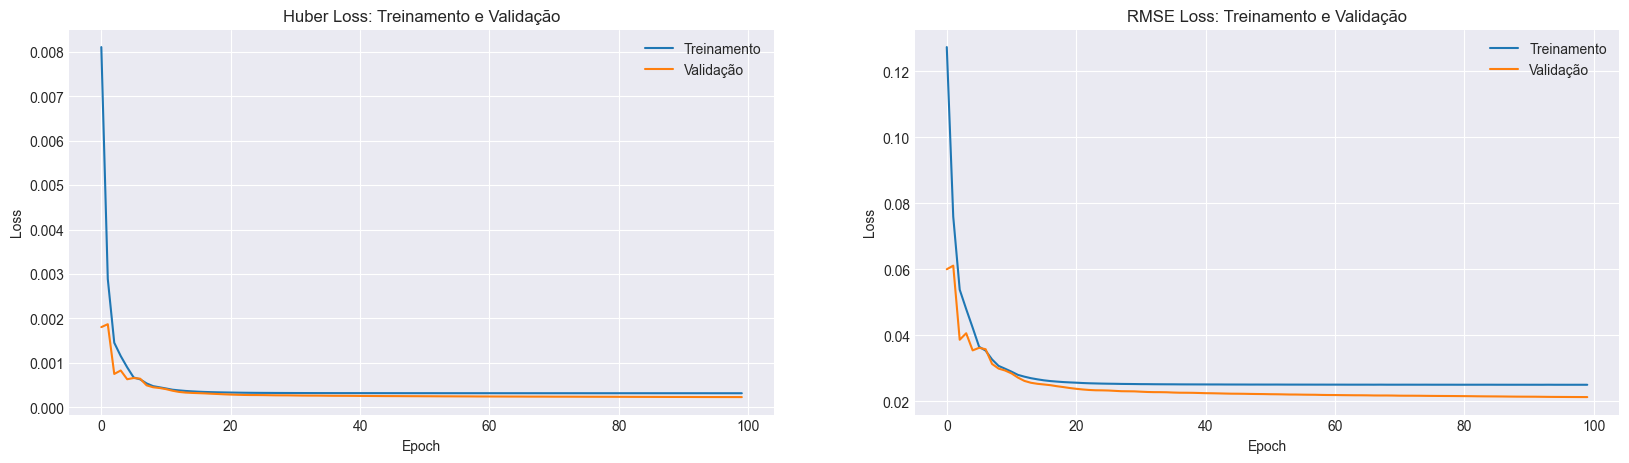

In [306]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Treinamento','Validação'])
plt.title('Huber Loss: Treinamento e Validação')
plt.subplot(1,2,2)
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Treinamento','Validação'])
plt.title('RMSE Loss: Treinamento e Validação')
plt.show()

In [307]:
model_1.evaluate(my_window.test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 1.4524e-04 - mae: 0.0130 - root_mean_squared_error: 0.0170


[0.00014524286962114275, 0.017043640837073326, 0.012973234057426453]

In [308]:
# Create new WindowGenerator with the data not shuffled:
my_window_2 = WindowGenerator(
    input_width=window_size,
    label_width=1,
    shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=label_cols,
    batch_size=batch_size,
    shuffle=False)

# plot_window(my_window_2.train,train_df,window_size,model_1)

In [309]:
# plot_window(my_window_2.val,val_df,window_size,model_1)

In [310]:
# plot_window(my_window_2.test,test_df,window_size,model_1)

https://github.com/Alejandro-Duenas/deep-learning-portfolio/blob/master/notebook.ipynb

In [311]:
columns = ['FR_'+ticker for ticker in tickers]
y_train = model_1.predict(my_window_2.train)
y_val = model_1.predict(my_window_2.val)
y_test = model_1.predict(my_window_2.test)
y_hat_total = np.concatenate([y_train,y_val,y_test],axis=0)
ret_hat_df = pd.DataFrame(data=y_hat_total,index=total_df.index[window_size:],columns=columns)
rfr = add_factors['selic'].agg(daily_rate)
#rfr = 0.025855
ret_hat_df = ret_hat_df.merge(rfr.rename('rfr'),left_index=True,right_index=True,
                             how='left')
# ret_hat_df.rolling(40).agg(lambda x: optimize_portfolio(
#     returns = ret_hat_df[ret_hat_df.columns[:-1]],
#     rfr = ret_hat_df[ret_hat_df.columns[-1]]))
opt_weights = np.array([optimize_portfolio(
    returns = window[ret_hat_df.columns[:-1]],
    rfr = window[ret_hat_df.columns[-1]],short=False).x for window in ret_hat_df.rolling(40)])
'''
opt_weights = np.array([optimize_portfolio(
    returns = window[ret_hat_df.columns[:-1]],
    rfr = 0.1075).x for window in ret_hat_df.rolling(40)])
'''
opt_weights.shape

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/stepWARNING:tensorflow:6 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000026ED8B42CA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


(1199, 15)

In [312]:
opt_weights[-1]
ret_hat_df[ret_hat_df.columns[:-1]][-40:]
ret_hat_df[ret_hat_df.columns[-1]][-40]

# sharpes = np.array([sharpe_ratio(weights=opt_weights[659][:],rfr=ret_hat_df.columns[-1],returns=ret_hat_df.columns[:-1])])
# opt_weights = np.array([optimize_portfolio(
#     returns = window[ret_hat_df.columns[:-1]],
    # rfr = window[ret_hat_df.columns[-1]],short=False).x for window in ret_hat_df.rolling(40)])


#[optimize_portfolio( returns = window[ret_hat_df.columns[:-1]],  rfr = window[ret_hat_df.columns[-1]],short=False).x for window in ret_hat_df.rolling(40)]


#ret_hat_df#.rolling(40)

#[print(window[ret_hat_df.columns[:-1]]) for window in ret_hat_df.rolling(40)]

#ret_hat_df.columns[-1]

#opt_weights[659].
#list(opt_weights[659][:])
#ret_hat_df

#sharpe_ratio(weights=opt_weights[659][:],rfr=ret_hat_df.columns[-1],returns=ret_hat_df.columns[:-1])

0.0001899886823872876

In [313]:
sr = sharpe_ratio(
  weights = opt_weights[-1],
  returns = ret_hat_df[ret_hat_df.columns[:-1]][-40:],
  rfr = ret_hat_df[ret_hat_df.columns[-1]][-40])

sr


4.886151124475479

Parte II

In [314]:
# opt_weights[-1]
ret_hat_df[ret_hat_df.columns[:-1]]
#ret_hat_df[ret_hat_df.columns[-1]][-40]


print(len(y_train))
print(len(y_val))
print(len(y_test))
y_hat_total = np.concatenate([y_train,y_val,y_test],axis=0)
print(len(y_hat_total))
print(total_df.index[5:])
# ret_hat_df = pd.DataFrame(data=y_hat_total,index=total_df.index[5:],columns=columns)


832
244
123
1199
DatetimeIndex(['2018-11-21', '2018-11-22', '2018-11-23', '2018-11-26',
               '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30',
               '2018-12-03', '2018-12-04',
               ...
               '2023-09-29', '2023-10-02', '2023-10-03', '2023-10-04',
               '2023-10-05', '2023-10-06', '2023-10-09', '2023-10-10',
               '2023-10-11', '2023-10-13'],
              dtype='datetime64[ns]', name='Date', length=1216, freq=None)


In [315]:
# ind_er2 = df2.resample('Y').last().pct_change().mean()
#df1.resample('Y').last().pct_change()


In [316]:
# df2
#df1  #['2021-06-07']#.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(trades_day))

#df1.loc[(1+df2).cumprod().div((1+df2).cumprod().iloc[0]).index[:1]]

In [317]:
# # ind_er2 = df2.resample('Y').last().pct_change().mean()
# #df2.resample('Y').last()#.mean() #TODO
# #df2.transform(lambda x: x + 1).rolling(2).prod()
# #(1+df2).cumprod().resample('Y').last().pct_change(periods=252)
#(1+df2).cumprod().resample('Y').last().pct_change()#.mean()


#df1.loc[(1+df2).cumprod().div((1+df2).cumprod().iloc[0]).index[:1]]

#(1+df2).cumprod().div((1+df2).cumprod().iloc[0]).index[:1]
#(1+df2).cumprod().div((1+df2).cumprod().iloc[0]).iloc[0] = df1.loc[(1+df2).cumprod().div((1+df2).cumprod().iloc[0]).index[:1]]
#(1+df2).cumprod().div((1+df2).cumprod().iloc[0])* (df1.loc[(1+df2).cumprod().div((1+df2).cumprod().iloc[0]).index[:1]].to_numpy())

#(1+df2).cumprod().div((1+df2).cumprod().iloc[0])
#(1+df2).cumprod().pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(trades_day))
#ann_sd2 = df2.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(trades_day))
#df1.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(trades_day))


In [318]:
ret_hat_df[ret_hat_df.columns[:-1]]

FR_CMIG3.SA  FR_ALUP11.SA  FR_ELET3.SA  FR_EGIE3.SA  FR_CPLE6.SA  \
Date                                                                           
2018-12-14     0.001755     -0.001157    -0.002448    -0.001894     0.004891   
2018-12-17     0.001893      0.000021    -0.001690    -0.002537     0.003446   
2018-12-18     0.002947      0.000773    -0.001312    -0.002709     0.001892   
2018-12-19     0.002766      0.000549    -0.000796    -0.002496     0.001060   
2018-12-20     0.002109      0.000549     0.000120    -0.001973     0.000382   
...                 ...           ...          ...          ...          ...   
2023-10-06    -0.004169      0.005124    -0.000224     0.003353     0.001056   
2023-10-09    -0.003562      0.004983     0.000473     0.001420    -0.000435   
2023-10-10    -0.002700      0.003320     0.000160    -0.001387    -0.002475   
2023-10-11    -0.001188      0.000913    -0.001614    -0.002156    -0.003468   
2023-10-13    -0.000360      0.000877    -0.002547    -0.001830    -0.002514   

            FR_BBAS3.SA  FR_BPAC11.SA  FR_BBDC4.SA  FR_ITUB4.SA  FR_SANB11.SA  \
Date                                                                            
2018-12-14    -0.000083      0.002280     0.001770    -0.001993      0.000848   
2018-12-17    -0.000768      0.001380     0.001811    -0.002029      0.000675   
2018-12-18    -0.000494      0.001589     0.001535    -0.002665     -0.000205   
2018-12-19    -0.000487      0.001932     0.001275    -0.002426     -0.000486   
2018-12-20    -0.000979      0.002663     0.000760    -0.001903     -0.000729   
...                 ...           ...          ...          ...           ...   
2023-10-06    -0.002129      0.003067     0.002335    -0.000495      0.001520   
2023-10-09    -0.000748      0.002870     0.001459     0.000482      0.000908   
2023-10-10    -0.000055      0.003263     0.001082     0.000200     -0.000052   
2023-10-11     0.000556      0.004399     0.002299    -0.002342     -0.000185   
2023-10-13    -0.000037      0.004695     0.004490    -0.003657     -0.000732   

            FR_CSMG3.SA  FR_SAPR4.SA  FR_SBSP3.SA  FR_BBSE3.SA  FR_PSSA3.SA  
Date                                                                         
2018-12-14     0.002396     0.002633    -0.000614     0.000190    -0.002122  
2018-12-17     0.001963     0.002164    -0.000236    -0.000061    -0.000215  
2018-12-18     0.002092     0.001989     0.000741     0.000038     0.001146  
2018-12-19     0.001759     0.002409     0.000716     0.000218     0.000989  
2018-12-20     0.000841     0.003136     0.000254     0.000373    -0.000047  
...                 ...          ...          ...          ...          ...  
2023-10-06     0.001833    -0.003806    -0.000733    -0.004514     0.004716  
2023-10-09     0.001615    -0.003830    -0.002150    -0.002809     0.003022  
2023-10-10     0.001855    -0.003599    -0.004308    -0.001105     0.001936  
2023-10-11     0.002379    -0.003217    -0.006783    -0.000458     0.001887  
2023-10-13     0.002445    -0.001833    -0.008011    -0.000605     0.002433  

[1199 rows x 15 columns]

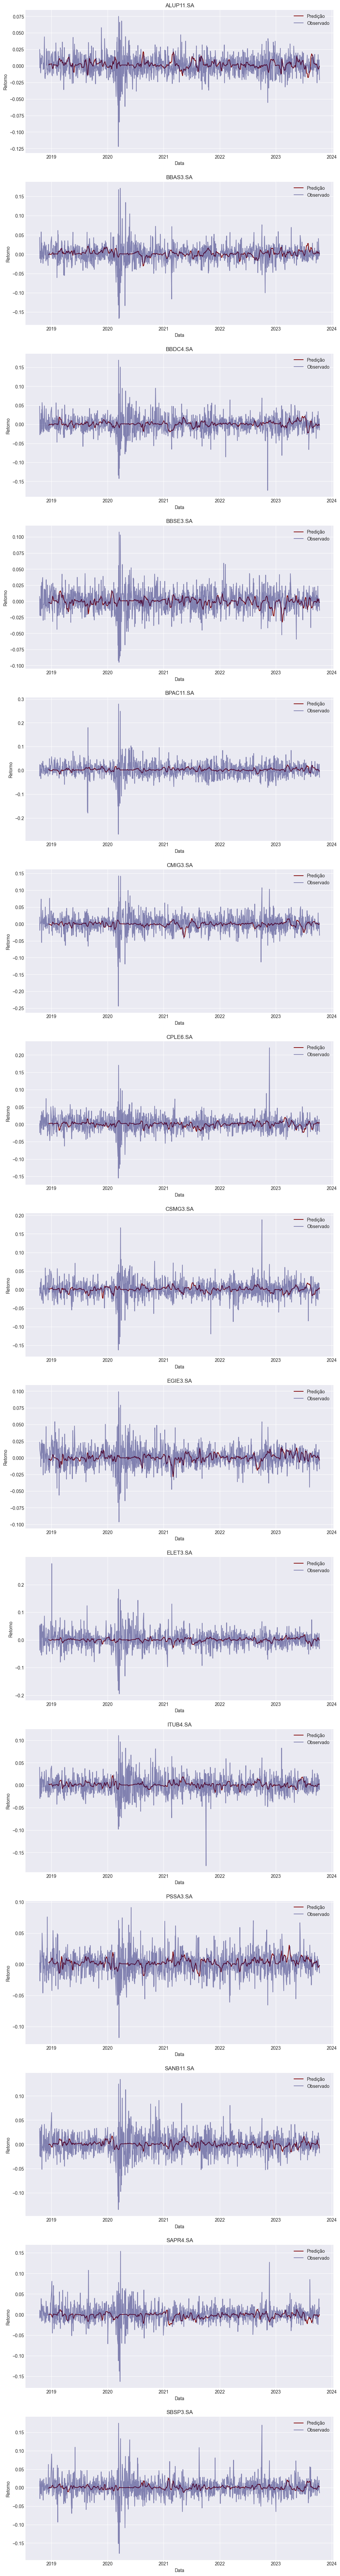

In [319]:
# plot_index = pandas_dataset.iloc[window_size:,:].index
# Plot the data:
plt.figure(figsize=(12,100))
for n in range(df1.shape[1]):
    plt.subplot(df1.shape[1],1,n+1)
    plt.ylabel('Retorno')
    plt.xlabel('Data')
    plt.title(df1.columns[n])
    plt.plot(ret_hat_df[ret_hat_df.columns[:-1]].index,ret_hat_df[ret_hat_df.columns[:-1]].iloc[:,n],label='Predição',color='maroon')
    plt.plot(df1[1:].index,df1.pct_change()[1:].iloc[:,n],label='Observado',color='midnightblue',alpha=0.5)
    plt.legend()    
plt.show()

In [320]:
# Log of percentage change

df2 = ret_hat_df[ret_hat_df.columns[:-1]]
# df2 = (1+df2).cumprod().div((1+df2).cumprod().iloc[0])* (df1.loc[(1+df2).cumprod().div((1+df2).cumprod().iloc[0]).index[:1]].to_numpy())
df2 = (1+df2).cumprod().div((1+df2).cumprod().iloc[0])* (df1.loc[(1+df2).cumprod().div((1+df2).cumprod().iloc[0]).index[:1].strftime('%Y-%m-%d')].to_numpy())

df2

FR_CMIG3.SA  FR_ALUP11.SA  FR_ELET3.SA  FR_EGIE3.SA  FR_CPLE6.SA  \
Date                                                                           
2018-12-14    13.510136     14.931542    17.290939    17.091564     4.762572   
2018-12-17    13.535717     14.931857    17.261726    17.048205     4.778983   
2018-12-18    13.575601     14.943399    17.239082    17.002028     4.788024   
2018-12-19    13.613144     14.951599    17.225356    16.959593     4.793101   
2018-12-20    13.641853     14.959810    17.227421    16.926137     4.794930   
...                 ...           ...          ...          ...          ...   
2023-10-06   132.889153    146.567792    47.602612     5.724923   173.799243   
2023-10-09   132.415785    147.298139    47.625116     5.733053   173.723611   
2023-10-10   132.058221    147.787106    47.632747     5.725101   173.293725   
2023-10-11   131.901278    147.922071    47.555855     5.712759   172.692808   
2023-10-13   131.853825    148.051753    47.434736     5.702302   172.258635   

            FR_BBAS3.SA  FR_BPAC11.SA  FR_BBDC4.SA  FR_ITUB4.SA  FR_SANB11.SA  \
Date                                                                            
2018-12-14     4.083012      1.992786    10.271260    24.106852     20.419943   
2018-12-17     4.079875      1.995535    10.289861    24.057936     20.433716   
2018-12-18     4.077858      1.998706    10.305651    23.993817     20.429524   
2018-12-19     4.075871      2.002567    10.318789    23.935604     20.419602   
2018-12-20     4.071879      2.007901    10.326629    23.890061     20.404728   
...                 ...           ...          ...          ...           ...   
2023-10-06     1.076058      1.908990    18.456838    32.646481     24.417563   
2023-10-09     1.075253      1.914469    18.483771    32.662218     24.439727   
2023-10-10     1.075194      1.920716    18.503778    32.668753     24.438463   
2023-10-11     1.075792      1.929165    18.546326    32.592239     24.433948   
2023-10-13     1.075752      1.938222    18.629595    32.473050     24.416056   

            FR_CSMG3.SA  FR_SAPR4.SA  FR_SBSP3.SA  FR_BBSE3.SA  FR_PSSA3.SA  
Date                                                                         
2018-12-14    27.700869    19.329897    28.731026     2.460795    26.811338  
2018-12-17    27.755253    19.371734    28.724248     2.460646    26.805561  
2018-12-18    27.813302    19.410262    28.745531     2.460739    26.836288  
2018-12-19    27.862224    19.457012    28.766122     2.461276    26.862829  
2018-12-20    27.885666    19.518023    28.773431     2.462193    26.861572  
...                 ...          ...          ...          ...          ...  
2023-10-06    98.318639   406.662079    50.283720     0.120553    83.888675  
2023-10-09    98.477429   405.104517    50.175589     0.120214    84.142194  
2023-10-10    98.660086   403.646428    49.959441     0.120082    84.305058  
2023-10-11    98.894794   402.347686    49.620557     0.120027    84.464118  
2023-10-13    99.136614   401.610124    49.223054     0.119954    84.669606  

[1199 rows x 15 columns]

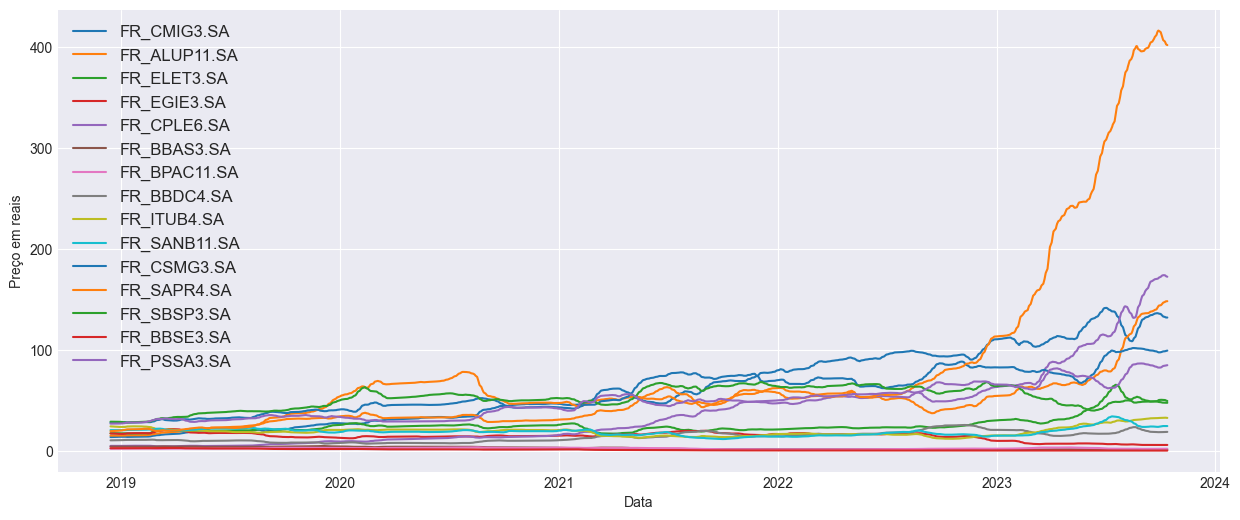

In [321]:
plt.figure(figsize=(15, 6))
for i in range(df2.shape[1]):
    plt.plot(df2.iloc[:,i], label=df2.columns.values[i])
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Preço em reais')
plt.xlabel('Data')
plt.show()

In [322]:
ret_hat_df[ret_hat_df.columns[:-1]]
# (1+df2).cumprod().div((1+df2).cumprod().iloc[0])
((1+ret_hat_df[ret_hat_df.columns[:-1]]).cumprod().div((1+ret_hat_df[ret_hat_df.columns[:-1]]).cumprod().iloc[0])-1)

FR_CMIG3.SA  FR_ALUP11.SA  FR_ELET3.SA  FR_EGIE3.SA  FR_CPLE6.SA  \
Date                                                                           
2018-12-14     0.000000      0.000000     0.000000     0.000000     0.000000   
2018-12-17     0.001894      0.000021    -0.001689    -0.002537     0.003446   
2018-12-18     0.004846      0.000794    -0.002999    -0.005239     0.005344   
2018-12-19     0.007625      0.001343    -0.003793    -0.007721     0.006410   
2018-12-20     0.009750      0.001893    -0.003673    -0.009679     0.006794   
...                 ...           ...          ...          ...          ...   
2023-10-06     8.836256      8.815985     1.753038    -0.665044    35.492729   
2023-10-09     8.801218      8.864898     1.754339    -0.664568    35.476849   
2023-10-10     8.774752      8.897645     1.754781    -0.665034    35.386585   
2023-10-11     8.763135      8.906684     1.750334    -0.665756    35.260410   
2023-10-13     8.759623      8.915369     1.743329    -0.666367    35.169247   

            FR_BBAS3.SA  FR_BPAC11.SA  FR_BBDC4.SA  FR_ITUB4.SA  FR_SANB11.SA  \
Date                                                                            
2018-12-14     0.000000      0.000000     0.000000     0.000000      0.000000   
2018-12-17    -0.000768      0.001380     0.001811    -0.002029      0.000674   
2018-12-18    -0.001262      0.002971     0.003348    -0.004689      0.000469   
2018-12-19    -0.001749      0.004908     0.004627    -0.007104     -0.000017   
2018-12-20    -0.002727      0.007585     0.005391    -0.008993     -0.000745   
...                 ...           ...          ...          ...           ...   
2023-10-06    -0.736455     -0.042050     0.796940     0.354241      0.195770   
2023-10-09    -0.736652     -0.039300     0.799562     0.354894      0.196856   
2023-10-10    -0.736667     -0.036165     0.801510     0.355165      0.196794   
2023-10-11    -0.736520     -0.031925     0.805652     0.351991      0.196573   
2023-10-13    -0.736530     -0.027380     0.813759     0.347046      0.195697   

            FR_CSMG3.SA  FR_SAPR4.SA  FR_SBSP3.SA  FR_BBSE3.SA  FR_PSSA3.SA  
Date                                                                         
2018-12-14     0.000000     0.000000     0.000000     0.000000     0.000000  
2018-12-17     0.001963     0.002164    -0.000236    -0.000061    -0.000215  
2018-12-18     0.004059     0.004158     0.000505    -0.000023     0.000931  
2018-12-19     0.005825     0.006576     0.001222     0.000196     0.001920  
2018-12-20     0.006671     0.009732     0.001476     0.000568     0.001874  
...                 ...          ...          ...          ...          ...  
2023-10-06     2.549298    20.037985     0.750154    -0.951010     2.128851  
2023-10-09     2.555030    19.957407     0.746390    -0.951148     2.138306  
2023-10-10     2.561624    19.881975     0.738867    -0.951202     2.144381  
2023-10-11     2.570097    19.814787     0.727072    -0.951224     2.150313  
2023-10-13     2.578827    19.776630     0.713237    -0.951254     2.157978  

[1199 rows x 15 columns]

In [323]:
df2.pct_change()


FR_CMIG3.SA  FR_ALUP11.SA  FR_ELET3.SA  FR_EGIE3.SA  FR_CPLE6.SA  \
Date                                                                           
2018-12-14          NaN           NaN          NaN          NaN          NaN   
2018-12-17     0.001894      0.000021    -0.001689    -0.002537     0.003446   
2018-12-18     0.002947      0.000773    -0.001312    -0.002709     0.001892   
2018-12-19     0.002765      0.000549    -0.000796    -0.002496     0.001060   
2018-12-20     0.002109      0.000549     0.000120    -0.001973     0.000382   
...                 ...           ...          ...          ...          ...   
2023-10-06    -0.004169      0.005124    -0.000224     0.003353     0.001056   
2023-10-09    -0.003562      0.004983     0.000473     0.001420    -0.000435   
2023-10-10    -0.002700      0.003320     0.000160    -0.001387    -0.002475   
2023-10-11    -0.001188      0.000913    -0.001614    -0.002156    -0.003468   
2023-10-13    -0.000360      0.000877    -0.002547    -0.001830    -0.002514   

            FR_BBAS3.SA  FR_BPAC11.SA  FR_BBDC4.SA  FR_ITUB4.SA  FR_SANB11.SA  \
Date                                                                            
2018-12-14          NaN           NaN          NaN          NaN           NaN   
2018-12-17    -0.000768      0.001380     0.001811    -0.002029      0.000674   
2018-12-18    -0.000494      0.001589     0.001535    -0.002665     -0.000205   
2018-12-19    -0.000487      0.001932     0.001275    -0.002426     -0.000486   
2018-12-20    -0.000980      0.002663     0.000760    -0.001903     -0.000728   
...                 ...           ...          ...          ...           ...   
2023-10-06    -0.002129      0.003067     0.002335    -0.000495      0.001520   
2023-10-09    -0.000748      0.002870     0.001459     0.000482      0.000908   
2023-10-10    -0.000055      0.003263     0.001082     0.000200     -0.000052   
2023-10-11     0.000556      0.004399     0.002299    -0.002342     -0.000185   
2023-10-13    -0.000037      0.004695     0.004490    -0.003657     -0.000732   

            FR_CSMG3.SA  FR_SAPR4.SA  FR_SBSP3.SA  FR_BBSE3.SA  FR_PSSA3.SA  
Date                                                                         
2018-12-14          NaN          NaN          NaN          NaN          NaN  
2018-12-17     0.001963     0.002164    -0.000236    -0.000061    -0.000215  
2018-12-18     0.002091     0.001989     0.000741     0.000038     0.001146  
2018-12-19     0.001759     0.002409     0.000716     0.000218     0.000989  
2018-12-20     0.000841     0.003136     0.000254     0.000372    -0.000047  
...                 ...          ...          ...          ...          ...  
2023-10-06     0.001833    -0.003806    -0.000733    -0.004514     0.004716  
2023-10-09     0.001615    -0.003830    -0.002150    -0.002809     0.003022  
2023-10-10     0.001855    -0.003599    -0.004308    -0.001105     0.001936  
2023-10-11     0.002379    -0.003218    -0.006783    -0.000458     0.001887  
2023-10-13     0.002445    -0.001833    -0.008011    -0.000605     0.002433  

[1199 rows x 15 columns]

In [324]:
# cov_matrix_pt2 = df2.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix_pt2 = df2.pct_change().apply(lambda x: np.log(1+x)).cov()
# (ret_hat_df[ret_hat_df.columns[:-1]])
# cov_matrix_pt2 = (ret_hat_df[ret_hat_df.columns[:-1]]).apply(lambda x: np.log(1+x)).cov()
cov_matrix_pt2

FR_CMIG3.SA  FR_ALUP11.SA   FR_ELET3.SA   FR_EGIE3.SA  \
FR_CMIG3.SA   2.791664e-05     -0.000005 -9.585998e-07 -6.291756e-07   
FR_ALUP11.SA -5.328828e-06      0.000046  2.092901e-06 -6.551765e-06   
FR_ELET3.SA  -9.585998e-07      0.000002  3.948396e-05  1.902432e-06   
FR_EGIE3.SA  -6.291756e-07     -0.000007  1.902432e-06  3.387746e-05   
FR_CPLE6.SA   2.699694e-06      0.000010 -4.292031e-06 -1.382902e-06   
FR_BBAS3.SA   1.092378e-05      0.000006 -1.473672e-05 -3.972645e-07   
FR_BPAC11.SA -1.175994e-05      0.000003 -1.040323e-05 -2.089746e-06   
FR_BBDC4.SA  -4.075421e-07     -0.000013 -9.368294e-06  1.096114e-05   
FR_ITUB4.SA  -3.835181e-06      0.000003  7.448259e-06 -1.138108e-06   
FR_SANB11.SA -8.573693e-06     -0.000003  1.238921e-05  3.581847e-07   
FR_CSMG3.SA   2.498092e-07      0.000006  2.485106e-06  9.163948e-07   
FR_SAPR4.SA  -4.373026e-06      0.000015  6.073759e-06 -1.069405e-05   
FR_SBSP3.SA  -4.337609e-06      0.000009  9.001468e-06  3.734219e-06   
FR_BBSE3.SA  -3.782008e-06     -0.000008  1.355590e-05  5.785341e-06   
FR_PSSA3.SA   7.482202e-08     -0.000001 -1.199056e-05  3.619238e-06   

               FR_CPLE6.SA   FR_BBAS3.SA  FR_BPAC11.SA   FR_BBDC4.SA  \
FR_CMIG3.SA   2.699694e-06  1.092378e-05 -1.175994e-05 -4.075421e-07   
FR_ALUP11.SA  1.002101e-05  5.656446e-06  2.824028e-06 -1.295621e-05   
FR_ELET3.SA  -4.292031e-06 -1.473672e-05 -1.040323e-05 -9.368294e-06   
FR_EGIE3.SA  -1.382902e-06 -3.972645e-07 -2.089746e-06  1.096114e-05   
FR_CPLE6.SA   3.081420e-05  4.359049e-06 -7.743015e-06 -4.830990e-06   
FR_BBAS3.SA   4.359049e-06  4.264757e-05  1.047472e-05 -5.266234e-06   
FR_BPAC11.SA -7.743015e-06  1.047472e-05  4.066767e-05 -1.645128e-06   
FR_BBDC4.SA  -4.830990e-06 -5.266234e-06 -1.645128e-06  4.022205e-05   
FR_ITUB4.SA   1.151868e-05 -1.865093e-06 -2.966043e-06 -7.959226e-06   
FR_SANB11.SA  1.713913e-06 -7.008931e-06  1.983287e-06 -5.758392e-06   
FR_CSMG3.SA  -9.322680e-07 -7.670148e-06 -1.009193e-06 -1.129513e-06   
FR_SAPR4.SA   5.298395e-06  7.546381e-07  4.800215e-06 -1.131301e-05   
FR_SBSP3.SA  -1.904280e-06 -9.609837e-06 -8.489948e-06 -8.573677e-06   
FR_BBSE3.SA  -1.487839e-05 -4.448355e-07  1.289563e-05  2.939717e-06   
FR_PSSA3.SA   7.830885e-07  8.304350e-06 -5.155390e-07  1.095773e-05   

              FR_ITUB4.SA  FR_SANB11.SA   FR_CSMG3.SA   FR_SAPR4.SA  \
FR_CMIG3.SA     -0.000004 -8.573693e-06  2.498092e-07 -4.373026e-06   
FR_ALUP11.SA     0.000003 -2.984112e-06  6.344148e-06  1.524843e-05   
FR_ELET3.SA      0.000007  1.238921e-05  2.485106e-06  6.073759e-06   
FR_EGIE3.SA     -0.000001  3.581847e-07  9.163948e-07 -1.069405e-05   
FR_CPLE6.SA      0.000012  1.713913e-06 -9.322680e-07  5.298395e-06   
FR_BBAS3.SA     -0.000002 -7.008931e-06 -7.670148e-06  7.546381e-07   
FR_BPAC11.SA    -0.000003  1.983287e-06 -1.009193e-06  4.800215e-06   
FR_BBDC4.SA     -0.000008 -5.758392e-06 -1.129513e-06 -1.131301e-05   
FR_ITUB4.SA      0.000027  1.339140e-05 -1.099390e-05  2.089947e-06   
FR_SANB11.SA     0.000013  3.610701e-05 -8.674787e-07  5.944722e-06   
FR_CSMG3.SA     -0.000011 -8.674787e-07  2.556486e-05  9.164223e-06   
FR_SAPR4.SA      0.000002  5.944722e-06  9.164223e-06  3.902962e-05   
FR_SBSP3.SA     -0.000001  2.148790e-06  5.761598e-06  5.260163e-06   
FR_BBSE3.SA     -0.000002  1.164310e-05 -3.621580e-06 -4.686118e-06   
FR_PSSA3.SA     -0.000005 -9.117647e-06  5.681443e-07 -2.019265e-06   

              FR_SBSP3.SA   FR_BBSE3.SA   FR_PSSA3.SA  
FR_CMIG3.SA     -0.000004 -3.782008e-06  7.482202e-08  
FR_ALUP11.SA     0.000009 -8.247701e-06 -1.326468e-06  
FR_ELET3.SA      0.000009  1.355590e-05 -1.199056e-05  
FR_EGIE3.SA      0.000004  5.785341e-06  3.619238e-06  
FR_CPLE6.SA     -0.000002 -1.487839e-05  7.830885e-07  
FR_BBAS3.SA     -0.000010 -4.448355e-07  8.304350e-06  
FR_BPAC11.SA    -0.000008  1.289563e-05 -5.155390e-07  
FR_BBDC4.SA     -0.000009  2.939717e-06  1.095773e-05  
FR_ITUB4.SA     -0.000001 -1.732120e-06 -4.828359e-06  
FR_SANB11.SA

In [325]:
# corr_matrix_pt2 = df2.pct_change().apply(lambda x: np.log(1+x)).corr()
corr_matrix_pt2 = df2.pct_change().apply(lambda x: np.log(1+x)).corr()
corr_matrix_pt2

FR_CMIG3.SA  FR_ALUP11.SA  FR_ELET3.SA  FR_EGIE3.SA  \
FR_CMIG3.SA      1.000000     -0.148385    -0.028873    -0.020459   
FR_ALUP11.SA    -0.148385      1.000000     0.049004    -0.165613   
FR_ELET3.SA     -0.028873      0.049004     1.000000     0.052017   
FR_EGIE3.SA     -0.020459     -0.165613     0.052017     1.000000   
FR_CPLE6.SA      0.092047      0.265599    -0.123049    -0.042802   
FR_BBAS3.SA      0.316588      0.127434    -0.359123    -0.010451   
FR_BPAC11.SA    -0.349019      0.065153    -0.259617    -0.056301   
FR_BBDC4.SA     -0.012162     -0.300564    -0.235081     0.296940   
FR_ITUB4.SA     -0.139152      0.091806     0.227238    -0.037486   
FR_SANB11.SA    -0.270048     -0.073065     0.328124     0.010241   
FR_CSMG3.SA      0.009351      0.184604     0.078219     0.031139   
FR_SAPR4.SA     -0.132481      0.359103     0.154721    -0.294096   
FR_SBSP3.SA     -0.165907      0.281484     0.289501     0.129656   
FR_BBSE3.SA     -0.114719     -0.194476     0.345749     0.159301   
FR_PSSA3.SA      0.002698     -0.037186    -0.363600     0.118483   

              FR_CPLE6.SA  FR_BBAS3.SA  FR_BPAC11.SA  FR_BBDC4.SA  \
FR_CMIG3.SA      0.092047     0.316588     -0.349019    -0.012162   
FR_ALUP11.SA     0.265599     0.127434      0.065153    -0.300564   
FR_ELET3.SA     -0.123049    -0.359123     -0.259617    -0.235081   
FR_EGIE3.SA     -0.042802    -0.010451     -0.056301     0.296940   
FR_CPLE6.SA      1.000000     0.120246     -0.218731    -0.137224   
FR_BBAS3.SA      0.120246     1.000000      0.251519    -0.127151   
FR_BPAC11.SA    -0.218731     0.251519      1.000000    -0.040676   
FR_BBDC4.SA     -0.137224    -0.127151     -0.040676     1.000000   
FR_ITUB4.SA      0.397799    -0.054751     -0.089164    -0.240589   
FR_SANB11.SA     0.051383    -0.178611      0.051757    -0.151103   
FR_CSMG3.SA     -0.033216    -0.232292     -0.031299    -0.035224   
FR_SAPR4.SA      0.152782     0.018497      0.120487    -0.285528   
FR_SBSP3.SA     -0.069327    -0.297383     -0.269046    -0.273201   
FR_BBSE3.SA     -0.429560    -0.010917      0.324087     0.074288   
FR_PSSA3.SA      0.026880     0.242300     -0.015404     0.329218   

              FR_ITUB4.SA  FR_SANB11.SA  FR_CSMG3.SA  FR_SAPR4.SA  \
FR_CMIG3.SA     -0.139152     -0.270048     0.009351    -0.132481   
FR_ALUP11.SA     0.091806     -0.073065     0.184604     0.359103   
FR_ELET3.SA      0.227238      0.328124     0.078219     0.154721   
FR_EGIE3.SA     -0.037486      0.010241     0.031139    -0.294096   
FR_CPLE6.SA      0.397799      0.051383    -0.033216     0.152782   
FR_BBAS3.SA     -0.054751     -0.178611    -0.232292     0.018497   
FR_BPAC11.SA    -0.089164      0.051757    -0.031299     0.120487   
FR_BBDC4.SA     -0.240589     -0.151103    -0.035224    -0.285528   
FR_ITUB4.SA      1.000000      0.427235    -0.416837     0.064132   
FR_SANB11.SA     0.427235      1.000000    -0.028552     0.158357   
FR_CSMG3.SA     -0.416837     -0.028552     1.000000     0.290119   
FR_SAPR4.SA      0.064132      0.158357     0.290119     1.000000   
FR_SBSP3.SA     -0.057540      0.072268     0.230286     0.170157   
FR_BBSE3.SA     -0.053218      0.310539    -0.114794    -0.120215   
FR_PSSA3.SA     -0.176372     -0.289122     0.021411    -0.061587   

              FR_SBSP3.SA  FR_BBSE3.SA  FR_PSSA3.SA  
FR_CMIG3.SA     -0.165907    -0.114719     0.002698  
FR_ALUP11.SA     0.281484    -0.194476    -0.037186  
FR_ELET3.SA      0.289501     0.345749    -0.363600  
FR_EGIE3.SA      0.129656     0.159301     0.118483  
FR_CPLE6.SA     -0.069327    -0.429560     0.026880  
FR_BBAS3.SA     -0.297383    -0.010917     0.242300  
FR_BPAC11.SA    -0.269046     0.324087    -0.015404  
FR_BBDC4.SA     -0.273201     0.074288     0.329218  
FR_ITUB4.SA     -0.057540    -0.053218    -0.176372  
FR_SANB11.SA     0.072268     0.310539    -0.289122  
FR_CSMG3.SA      0.230286    -0.114794     0.021411  
FR_SAPR4.SA      0.170157    -0.120215    -0.061587

In [326]:
df2.columns
w2 = dict()
df2.columns.size
for i in df2.columns:
  w2.setdefault(i, 1/df2.columns.size)

# w = {'CMIG3.SA': 0.05, 'ALUP11.SA': 0.05,'ELET3.SA': 0.05,'EGIE3.SA': 0.05,'CPLE6.SA': 0.05,
#     'BBAS3.SA': 0.05, 'BPAC11.SA': 0.05,'BBDC4.SA': 0.05,'ITUB4.SA': 0.05,'SANB11.SA': 0.05,
#     'AMBP3.SA': 0.05, 'CSMG3.SA': 0.05, 'SAPR4.SA': 0.05, 'SBSP3.SA': 0.05, 'ORVR3.SA': 0.05,
#     'BBSE3.SA': 0.05, 'CXSE3.SA': 0.1, 'PSSA3.SA': 0.1
#      }

port_var2 = cov_matrix_pt2.mul(w2, axis=0).mul(w2, axis=1).sum().sum()
port_var2

2.072115842345661e-06

In [327]:

# Yearly returns for individual companies
ind_er2 = df2.resample('Y').last().pct_change().mean()
#ind_er2 = (1+df2).cumprod().resample('Y').last().pct_change().mean()
ind_er2.sort_index()

FR_ALUP11.SA    0.875209
FR_BBAS3.SA    -0.199617
FR_BBDC4.SA     0.162689
FR_BBSE3.SA    -0.407186
FR_BPAC11.SA    0.062620
FR_CMIG3.SA     0.595000
FR_CPLE6.SA     1.139867
FR_CSMG3.SA     0.302269
FR_EGIE3.SA    -0.156831
FR_ELET3.SA     0.262632
FR_ITUB4.SA     0.146780
FR_PSSA3.SA     0.258558
FR_SANB11.SA    0.079001
FR_SAPR4.SA     0.999865
FR_SBSP3.SA     0.156062
dtype: float64

In [328]:
#w = [0.05, 0.05
#]
port_er2 = (list(w2.values())*ind_er2).sum()
port_er2

0.2851277028661962

In [329]:
# Volatility is given by the annual standard deviation. We multiply by 250 because there are 250 trading days/year.
trades_day=252
ann_sd2 = df2.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(trades_day))
#ann_sd2 = (1+df2).cumprod().pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(trades_day))
ann_sd2.sort_values(ascending=False)

FR_ALUP11.SA    0.107897
FR_BBAS3.SA     0.103669
FR_BPAC11.SA    0.101234
FR_BBDC4.SA     0.100677
FR_ELET3.SA     0.099749
FR_SAPR4.SA     0.099174
FR_BBSE3.SA     0.099050
FR_SANB11.SA    0.095389
FR_EGIE3.SA     0.092397
FR_CPLE6.SA     0.088120
FR_CMIG3.SA     0.083875
FR_PSSA3.SA     0.083312
FR_ITUB4.SA     0.082806
FR_CSMG3.SA     0.080264
FR_SBSP3.SA     0.078551
dtype: float64

In [330]:
assets2 = pd.concat([ind_er2, ann_sd2], axis=1) # Creating a table for visualising returns and volatility of assets
assets2.columns = ['Returns', 'Volatility']
assets2

Returns  Volatility
FR_CMIG3.SA   0.595000    0.083875
FR_ALUP11.SA  0.875209    0.107897
FR_ELET3.SA   0.262632    0.099749
FR_EGIE3.SA  -0.156831    0.092397
FR_CPLE6.SA   1.139867    0.088120
FR_BBAS3.SA  -0.199617    0.103669
FR_BPAC11.SA  0.062620    0.101234
FR_BBDC4.SA   0.162689    0.100677
FR_ITUB4.SA   0.146780    0.082806
FR_SANB11.SA  0.079001    0.095389
FR_CSMG3.SA   0.302269    0.080264
FR_SAPR4.SA   0.999865    0.099174
FR_SBSP3.SA   0.156062    0.078551
FR_BBSE3.SA  -0.407186    0.099050
FR_PSSA3.SA   0.258558    0.083312

In [331]:
p_ret2 = [] # Define an empty array for portfolio returns
p_vol2 = [] # Define an empty array for portfolio volatility
p_weights2 = [] # Define an empty array for asset weights

num_assets2 = len(df2.columns)
num_portfolios2 = num_portfolios

for portfolio2 in range(num_portfolios):
    weights2 = np.random.random(num_assets2)
    weights2 = weights2/np.sum(weights2)
    p_weights2.append(weights2)
    returns2 = np.dot(weights2, ind_er2) # Returns are the product of individual expected returns of asset and its
                                      # weights
    p_ret2.append(returns2)
    var2 = cov_matrix_pt2.mul(weights2, axis=0).mul(weights2, axis=1).sum().sum()# Portfolio Variance
    sd2 = np.sqrt(var2) # Daily standard deviation
    ann_sd2 = sd2*np.sqrt(trades_day) # Annual standard deviation = volatility
    p_vol2.append(ann_sd2)

data2 = {'Returns':p_ret2, 'Volatility':p_vol2}

for counter2, symbol2 in enumerate(df2.columns.tolist()):
    #print(counter, symbol)
    data2[symbol2+' weight'] = [w2[counter2] for w2 in p_weights2]

portfolios2  = pd.DataFrame(data2)
portfolios2.head() # Dataframe of the 10000 portfolios created

Returns  Volatility  FR_CMIG3.SA weight  FR_ALUP11.SA weight  \
0  0.383130    0.025843            0.089923             0.077686   
1  0.208590    0.027452            0.080282             0.097656   
2  0.215517    0.025032            0.035275             0.096397   
3  0.285434    0.023328            0.112272             0.080127   
4  0.229944    0.024421            0.036228             0.057714   

   FR_ELET3.SA weight  FR_EGIE3.SA weight  FR_CPLE6.SA weight  \
0            0.072353            0.083730            0.112074   
1            0.105802            0.089159            0.010783   
2            0.045128            0.042306            0.001547   
3            0.081318            0.117783            0.038216   
4            0.060639            0.033117            0.019144   

   FR_BBAS3.SA weight  FR_BPAC11.SA weight  FR_BBDC4.SA weight  \
0            0.042925             0.063746            0.032894   
1            0.012700             0.115029            0.031636   
2            0.107332             0.074366            0.111716   
3            0.036085             0.094137            0.101394   
4            0.106514             0.042778            0.091155   

   FR_ITUB4.SA weight  FR_SANB11.SA weight  FR_CSMG3.SA weight  \
0            0.046842             0.047401            0.071963   
1            0.088998             0.051149            0.116098   
2            0.087012             0.055759            0.088823   
3            0.046156             0.072416            0.053131   
4            0.022737             0.130264            0.126762   

   FR_SAPR4.SA weight  FR_SBSP3.SA weight  FR_BBSE3.SA weight  \
0            0.108313            0.002085            0.078168   
1            0.018086            0.003223            0.116749   
2            0.059151            0.028112            0.073572   
3            0.027510            0.017059            0.005258   
4            0.047850            0.072002            0.032345   

   FR_PSSA3.SA weight  
0            0.069897  
1            0.062650  
2            0.093503  
3            0.117138  
4            0.120750

In [332]:
portfolios2['Volatility'].diff

<bound method Series.diff of 0        0.025843
1        0.027452
2        0.025032
3        0.023328
4        0.024421
           ...   
99995    0.026047
99996    0.025495
99997    0.022395
99998    0.026650
99999    0.025305
Name: Volatility, Length: 100000, dtype: float64>

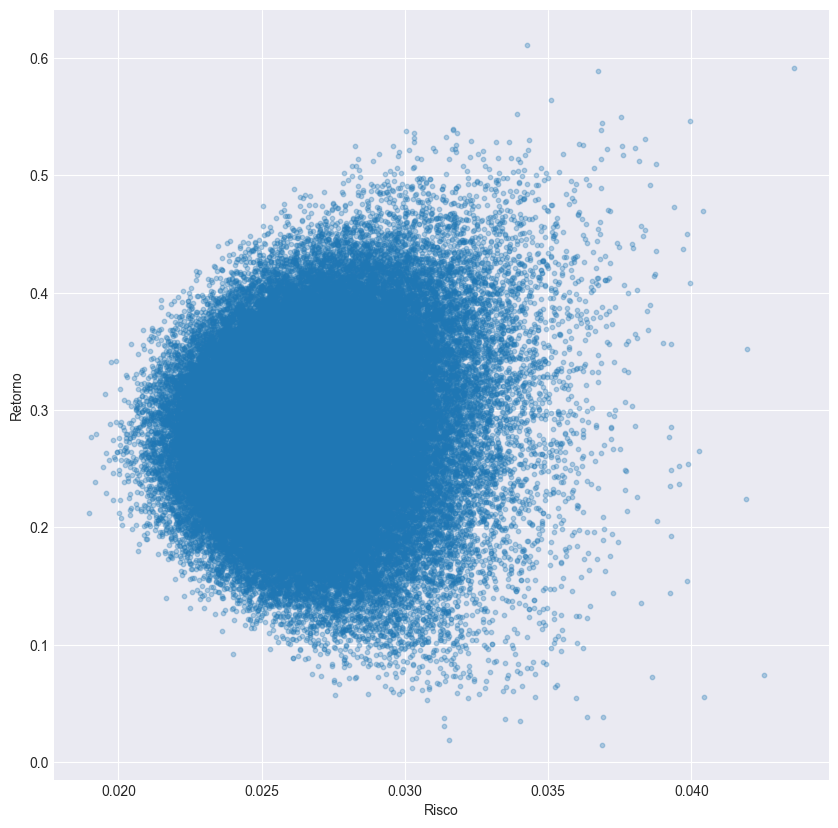

In [333]:
# Plot efficient frontier
portfolios2.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])
plt.ylabel('Retorno')
plt.xlabel('Risco')
plt.show()

In [334]:
min_vol_port2 = portfolios2.iloc[portfolios2['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.
min_vol_port2#.sort_values(ascending=False)

Returns                0.212290
Volatility             0.018974
FR_CMIG3.SA weight     0.109433
FR_ALUP11.SA weight    0.000855
FR_ELET3.SA weight     0.050881
FR_EGIE3.SA weight     0.008526
FR_CPLE6.SA weight     0.031649
FR_BBAS3.SA weight     0.072915
FR_BPAC11.SA weight    0.079006
FR_BBDC4.SA weight     0.120802
FR_ITUB4.SA weight     0.109394
FR_SANB11.SA weight    0.029126
FR_CSMG3.SA weight     0.112128
FR_SAPR4.SA weight     0.014611
FR_SBSP3.SA weight     0.117964
FR_BBSE3.SA weight     0.050900
FR_PSSA3.SA weight     0.091810
Name: 10692, dtype: float64

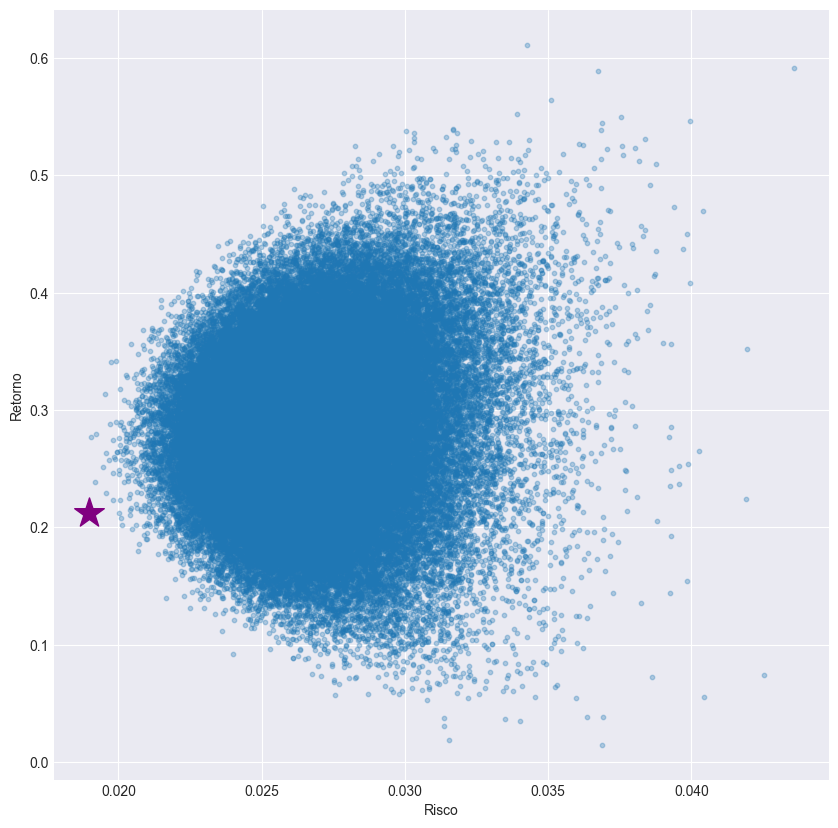

In [335]:
plt.subplots(figsize=[10,10])
plt.scatter(portfolios2['Volatility'], portfolios2['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port2[1], min_vol_port2[0], color='purple', marker='*', s=500)
plt.ylabel('Retorno')
plt.xlabel('Risco')
plt.show()

In [336]:
# Finding the optimal portfolio
#rf = 0.1075 # risk factor
optimal_risky_port2 = portfolios2.iloc[((portfolios2['Returns']-rf)/portfolios2['Volatility']).idxmax()]

print(f"id: {((portfolios2['Returns']-rf)/portfolios2['Volatility']).idxmax()}")
print(f"sharpe: {((portfolios2['Returns']-rf)/portfolios2['Volatility'])[((portfolios2['Returns']-rf)/portfolios2['Volatility']).idxmax()]} ")

optimal_risky_port2#.sort_values(ascending=False)

id: 96981
sharpe: 14.771063881407684 


Returns                0.524821
Volatility             0.028253
FR_CMIG3.SA weight     0.095679
FR_ALUP11.SA weight    0.101415
FR_ELET3.SA weight     0.092832
FR_EGIE3.SA weight     0.072687
FR_CPLE6.SA weight     0.149463
FR_BBAS3.SA weight     0.003438
FR_BPAC11.SA weight    0.050576
FR_BBDC4.SA weight     0.098667
FR_ITUB4.SA weight     0.017821
FR_SANB11.SA weight    0.038664
FR_CSMG3.SA weight     0.020199
FR_SAPR4.SA weight     0.138186
FR_SBSP3.SA weight     0.030221
FR_BBSE3.SA weight     0.001078
FR_PSSA3.SA weight     0.089074
Name: 96981, dtype: float64

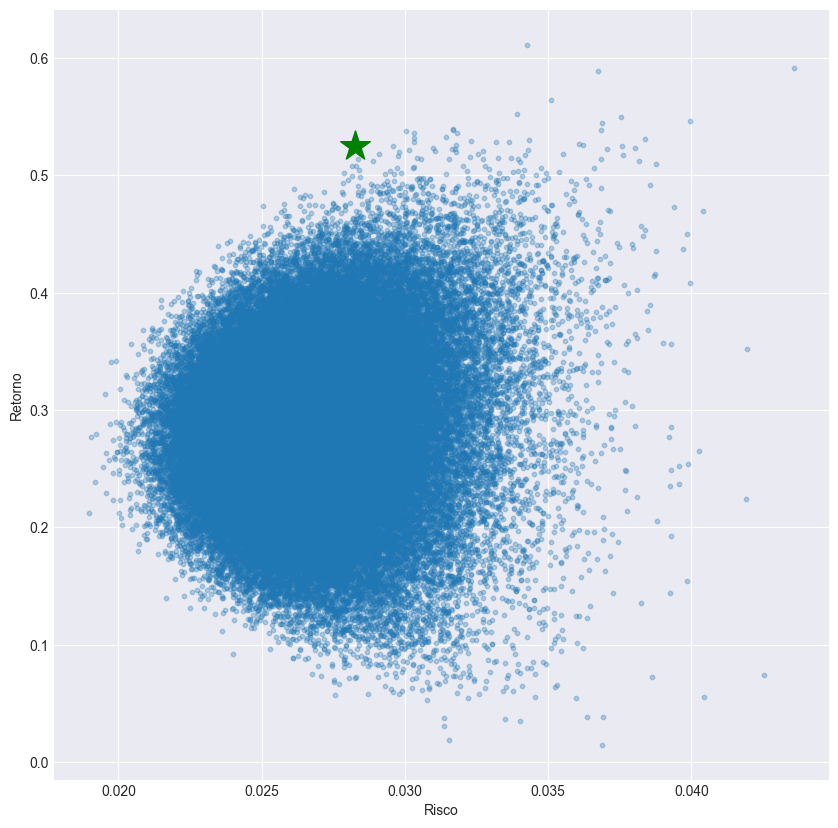

In [337]:
# Plotting optimal portfolio
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios2['Volatility'], portfolios2['Returns'],marker='o', s=10, alpha=0.3)
#plt.scatter(portfolios2['Volatility'], portfolios2['Returns'],c=((portfolios2['Returns']-rf)/portfolios2['Volatility']), cmap = 'viridis', s=10, alpha=0.3)
#plt.scatter(min_vol_port2[1], min_vol_port2[0], color='purple', marker='*', s=500)
plt.scatter(optimal_risky_port2[1], optimal_risky_port2[0], color='g', marker='*', s=500)
plt.ylabel('Retorno')
plt.xlabel('Risco')
plt.show()

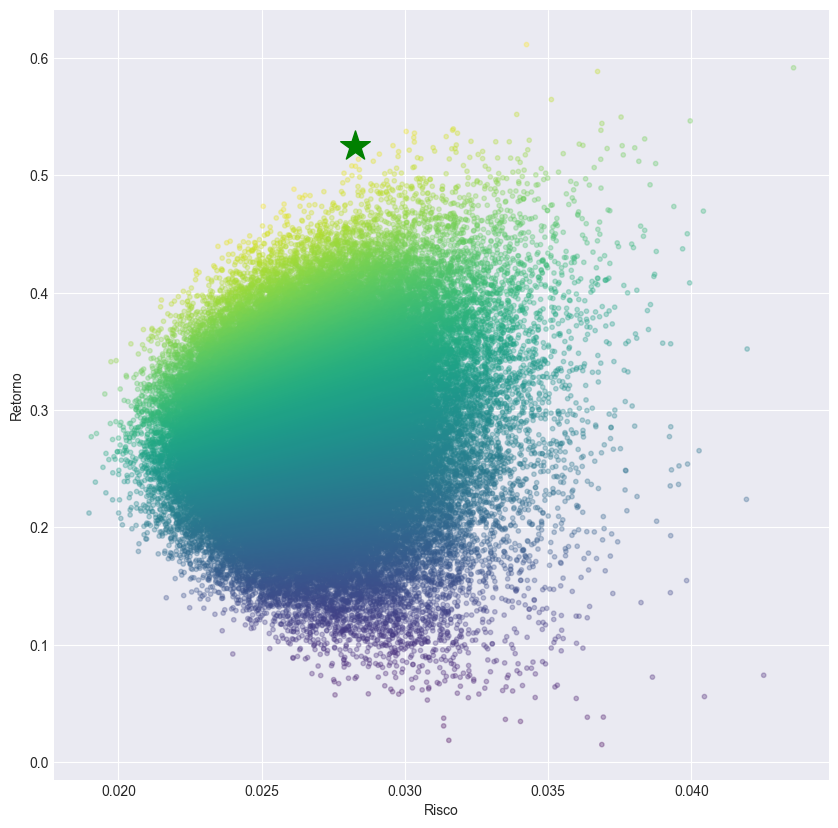

In [338]:
# Plotting optimal portfolio
plt.subplots(figsize=(10, 10))
# plt.scatter(portfolios2['Volatility'], portfolios2['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(portfolios2['Volatility'], portfolios2['Returns'],c=((portfolios2['Returns']-rf)/portfolios2['Volatility']), cmap = 'viridis', s=10, alpha=0.3)
#plt.scatter(min_vol_port2[1], min_vol_port2[0], color='purple', marker='*', s=500)
plt.scatter(optimal_risky_port2[1], optimal_risky_port2[0], color='g', marker='*', s=500)
plt.ylabel('Retorno')
plt.xlabel('Risco')
plt.show()

PARTE III

In [339]:
start_date2 = pd.to_datetime(end_date)+pd.DateOffset(1)
end_date2 = pd.to_datetime(start_date2)+pd.DateOffset(months=12)

print(start_date2)
print(end_date2)

df_tmp = yf.download(
   tickers
   ,start = start_date2, end= end_date2).stack()

df_tmp

df_tmp.index.names = ['date', 'ticker']

df_tmp.columns = df_tmp.columns.str.lower()

#df1=df['Adj Close']
df_tmp=df_tmp.unstack('ticker')['adj close']

df_tmp

[*********************100%***********************]  15 of 15 completed

2023-10-16 00:00:00
2024-10-16 00:00:00


ticker                     ALUP11.SA   BBAS3.SA   BBDC4.SA   BBSE3.SA  \
date                                                                    
2023-10-16 00:00:00+00:00  26.225849  23.434443  13.605262  29.392626   
2023-10-17 00:00:00+00:00  25.876293  23.222731  13.465860  29.318428   
2023-10-18 00:00:00+00:00  25.627928  23.109812  13.345050  29.578127   
2023-10-19 00:00:00+00:00  25.637123  23.288593  13.410103  29.550304   
2023-10-20 00:00:00+00:00  26.005077  23.213318  13.159187  29.160751   
...                              ...        ...        ...        ...   
2024-10-09 00:00:00+00:00  29.400000  26.430000  14.899936  33.849998   
2024-10-10 00:00:00+00:00  29.500000  26.200001  14.979828  33.840000   
2024-10-11 00:00:00+00:00  29.299999  26.330000  14.780097  33.860001   
2024-10-14 00:00:00+00:00  29.299999  26.520000  14.999802  33.970001   
2024-10-15 00:00:00+00:00  29.650000  26.469999  15.129626  33.930000   

ticker                     BPAC11.SA   CMIG3.SA   CPLE6.SA   CSMG3.SA  \
date                                                                    
2023-10-16 00:00:00+00:00  30.118071  12.147453   8.259729  14.860214   
2023-10-17 00:00:00+00:00  29.541695  11.567719   8.132507  14.351953   
2023-10-18 00:00:00+00:00  28.691786  10.987986   7.917206  14.007368   
2023-10-19 00:00:00+00:00  28.584324  11.028431   8.152080  14.015984   
2023-10-20 00:00:00+00:00  28.555017  10.785752   8.171652  13.903992   
...                              ...        ...        ...        ...   
2024-10-09 00:00:00+00:00  32.419998  14.230000  10.110000  22.299999   
2024-10-10 00:00:00+00:00  31.990000  14.150000  10.110000  22.250000   
2024-10-11 00:00:00+00:00  32.150002  14.160000  10.020000  21.910000   
2024-10-14 00:00:00+00:00  32.619999  14.210000  10.120000  21.940001   
2024-10-15 00:00:00+00:00  33.099998  14.240000  10.120000  22.090000   

ticker                      EGIE3.SA   ELET3.SA   ITUB4.SA   PSSA3.SA  \
date                                                                    
2023-10-16 00:00:00+00:00  38.864647  35.228584  25.868048  25.119299   
2023-10-17 00:00:00+00:00  38.458530  34.536079  25.485580  24.945061   
2023-10-18 00:00:00+00:00  37.910740  33.408291  24.953852  24.635303   
2023-10-19 00:00:00+00:00  38.354637  33.447865  25.243036  24.664343   
2023-10-20 00:00:00+00:00  38.364079  33.744652  25.149750  24.586905   
...                              ...        ...        ...        ...   
2024-10-09 00:00:00+00:00  41.000000  38.189999  34.682510  36.900002   
2024-10-10 00:00:00+00:00  40.930000  38.139999  34.872414  36.840000   
2024-10-11 00:00:00+00:00  40.590000  38.130001  34.612549  36.259998   
2024-10-14 00:00:00+00:00  40.750000  38.919998  34.832432  36.610001   
2024-10-15 00:00:00+00:00  41.160000  38.700001  35.232235  36.950001   

ticker                     SANB11.SA  SAPR4.SA   SBSP3.SA  
date                                                       
2023-10-16 00:00:00+00:00  25.559807  4.559944  61.714306  
2023-10-17 00:00:00+00:00  24.972116  4.455227  60.201168  
2023-10-18 00:00:00+00:00  24.729580  4.302912  58.471870  
2023-10-19 00:00:00+00:00  25.009430  4.236273  59.336521  
2023-10-20 00:00:00+00:00  24.823200  4.312432  58.403091  
...                              ...       ...        ...  
2024-10-09 00:00:00+00:00  28.066982  5.590000  88.949997  
2024-10-10 00:00:00+00:00  28.254690  5.550000  88.669998  
2024-10-11 00:00:00+00:00  28.234930  5.550000  88.099998  
2024-10-14 00:00:00+00:00  28.560946  5.650000  90.010002  
2024-10-15 00:00:00+00:00  28.590584  5.630000  91.099998  

[252 rows x 15 columns]

In [340]:
df_tmp[-1:].to_numpy()

df_final = (df_tmp[-1:].to_numpy() - df_tmp[:1].to_numpy())/ df_tmp[:1].to_numpy()
# df_final = pd.DataFrame(df_final)
print(f"MK = {(df_final*optimal_risky_port[2:].to_numpy()).sum(axis=1)}")
print(f"LSTM = {(df_final*optimal_risky_port2[2:].to_numpy()).sum(axis=1)}")

print(f"LSTM[-1] = {(df_final*opt_weights[-1]).sum(axis=1)}")

# rets = w.dot(ef.expected_returns).dot(df_final.transpose())
# pd.DataFrame(optimal_risky_port2[2:].to_numpy()).transpose()
# pd.DataFrame(optimal_risky_port2[2:].to_numpy()).dot(df_final)


MK = [0.16938916]
LSTM = [0.24554218]
LSTM[-1] = [0.21457545]


In [341]:
opt_weights[-1]

array([1.19281782e-01, 1.60853024e-01, 0.00000000e+00, 0.00000000e+00,
       8.03112623e-02, 1.24398831e-01, 2.52238041e-01, 7.82674130e-14,
       0.00000000e+00, 0.00000000e+00, 2.41068385e-01, 0.00000000e+00,
       3.60036496e-03, 1.82483099e-02, 0.00000000e+00])

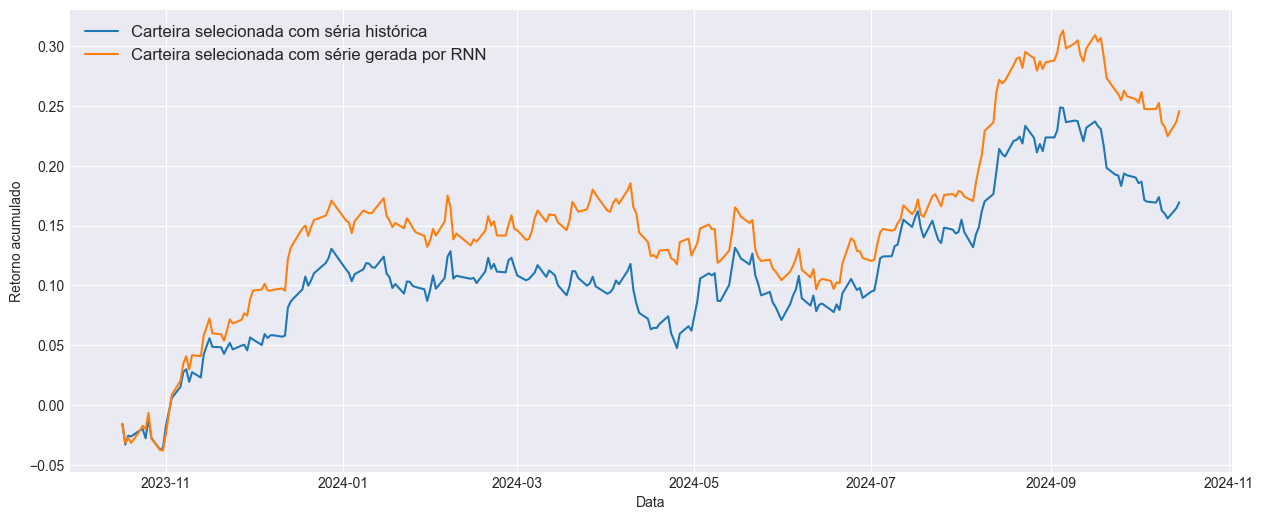

In [342]:
#((1+ret_hat_df[ret_hat_df.columns[:-1]]).cumprod().div((1+ret_hat_df[ret_hat_df.columns[:-1]]).cumprod().iloc[0])-1)

# ((((1+df_tmp.pct_change()).cumprod()*optimal_risky_port[2:].to_numpy()).sum(axis=1))-1)[1:]
#((((1+df_tmp.pct_change()).cumprod()*optimal_risky_port2[2:].to_numpy()).sum(axis=1))-1)[1:]


plt.figure(figsize=(15, 6))
plt.plot(((((1+df_tmp.pct_change()).cumprod()*optimal_risky_port[2:].to_numpy()).sum(axis=1))-1)[1:], label="Carteira selecionada com séria histórica")
plt.plot(((((1+df_tmp.pct_change()).cumprod()*optimal_risky_port2[2:].to_numpy()).sum(axis=1))-1)[1:], label="Carteira selecionada com série gerada por RNN")
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Retorno acumulado')
plt.xlabel('Data')
plt.show()